# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import inflection

import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from IPython.display import Image
from IPython.core.display import HTML
import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat)) 
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE':mae,
                        'RMSE':rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=True):
    mae_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('Kfold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training.index.max() - datetime.timedelta(days=k*90)
        validation_end_date = x_training.index.max() - datetime.timedelta(days=(k-1)*90)

        # filtering dataset
        training = x_training[x_training.index < validation_start_date]
        validation = x_training[(x_training.index >= validation_start_date) & (x_training.index <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['daily_return_pct','symbol'], axis=1)
        ytraining = training['daily_return_pct']

        xvalidation = validation.drop(['daily_return_pct','symbol'],axis=1)
        yvalidation = validation['daily_return_pct']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, yvalidation, yhat) #np.expm1(yvalidation), np.expm1(yhat))

        # store perfomance of each kfold iteration
        mae_list.append(m_result['MAE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model':model_name,
        'MAE cv': np.round(np.mean(mae_list),5).astype(str) + '+/-' + np.round(np.std(mae_list),4).astype(str),
        'RMSE cv': np.round(np.mean(rmse_list),5).astype(str) + '+/-' + np.round(np.std(rmse_list),4).astype(str)}, index=[0])


def descriptive_statistics(num):
    # Central Tendency - mean, median

    ct1 = pd.DataFrame(num.apply(np.mean)).T
    ct2 = pd.DataFrame(num.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, curtosis
    d1 = pd.DataFrame(num.apply(min)).T
    d2 = pd.DataFrame(num.apply(max)).T
    d3 = pd.DataFrame(num.apply(lambda x: x.max()-x.min())).T
    d4 = pd.DataFrame(num.apply(np.std)).T
    d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T

    ctd = pd.concat([ct1,ct2,d1,d2,d3,d4,d5,d6]).T.reset_index()
    ctd.columns = ['features', 'mean','median','min','max','range','std','skew','kurtosis']
    return ctd


def plot_candles(asset_name, df, days):
    df = df.iloc[0:days]
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])],
                layout=go.Layout(
                            title=go.layout.Title(text='{} Candlestick Chart from {}-{}-{} to {}-{}-{}'.format(asset_name, df.index[-1:].year[0],df.index[-1:].month[0], df.index[-1:].day[0],df.index[0].year, df.index[0].month,df.index[0].day))))
    return fig.show()

def plot_cum_return(asset_name, df):
    plt.title('{} Cumulative Return'.format(asset_name));
    (1+df[::-1].daily_return_pct).cumprod().plot();
    plt.xticks(rotation='45');
    return plt.show()
    
def plot_cumreturn_day_of_year(asset_name, df):
    plt.title('{} - Daily Return Cumulative Sum per Day of the Year'.format(asset_name))
    (1+df.groupby(df.index.day_of_year)['daily_return_pct'].mean()).cumprod().plot()
    return plt.show()

def plot_mean_month(asset_name, df):
    plt.title('{} - Mean Daily Return Percentage per Month'.format(asset_name))
    df.groupby(df.index.month)['daily_return_pct'].mean().plot.bar();
    return plt.show()
def plot_median_month(asset_name, df):
    plt.title('{} - Median Daily Return Percentage per Month'.format(asset_name))
    df.groupby(df.index.month).median()['daily_return_pct'].plot.bar()
    return plt.show()
def plot_daily_sum_per_month(asset_name, df, month):
    m = df[df.index.month==month]
    plt.title('{} - Daily Return Percentage Mean per Month ({})'.format(asset_name, month))
    m.groupby(m.index.day)['daily_return_pct'].sum().plot.bar()
    plt.xticks(rotation='45');
    return plt.show()
def concat_return(dolar, bova11, smal11, bitcoin, ether):
    full_return_pct = dolar[['daily_return_pct']].copy()
    full_return_pct.rename(columns= {'daily_return_pct':'dolar'}, inplace=True)
    full_return_pct = full_return_pct.merge(bova11.daily_return_pct, left_index=True, right_index=True, how='outer')
    full_return_pct.rename(columns= {'daily_return_pct':'bova11'}, inplace=True)
    full_return_pct = full_return_pct.merge(smal11.daily_return_pct, left_index=True, right_index=True, how='outer')
    full_return_pct.rename(columns= {'daily_return_pct':'smal11'}, inplace=True)
    full_return_pct = full_return_pct.merge(bitcoin.daily_return_pct, left_index=True, right_index=True, how='outer')
    full_return_pct.rename(columns= {'daily_return_pct':'bitcoin'}, inplace=True)
    full_return_pct = full_return_pct.merge(ether.daily_return_pct, left_index=True, right_index=True, how='outer')
    full_return_pct.rename(columns= {'daily_return_pct':'ether'}, inplace=True)
    return full_return_pct
def plot_volatility(asset_name, df):
    plt.subplot(2,1,1)
    print('{} Standard Deviation: {}'.format(asset_name, df.daily_return_pct.std().round(5)))
    plt.title('{} - Daily Return Percentage - Histogram '.format(asset_name));
    df.daily_return_pct.hist();
    plt.tight_layout();

    plt.subplot(2,1,2)
    plt.title('{} - Daily Return Percentage - Volatility Moving Average (30 days)'.format(asset_name));
    df.daily_return_pct.rolling(window=30).std().plot();
    plt.tight_layout();
    return plt.show()

def merge_returns(d2):
    if d2 is dolar_f:
        d2 = pd.merge(left= dolar_f, right= bova11.daily_return_pct, left_index=True, right_index=True, how='outer')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)
        d2 = pd.merge(left= d2, right= smal11.daily_return_pct, left_index=True, right_index=True,how='outer')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)
        d2 = pd.merge(left= d2, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='outer')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)
        d2 = pd.merge(left= d2, right= ether.daily_return_pct, left_index=True, right_index=True,how='outer')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)
        d2 = d2[d2['daily_return_pct'].notna()]
        d2.fillna(method='ffill', inplace=True)
        d2.fillna(0, inplace=True)

    elif d2 is bova11_f:
        # Bova11
        d2 = pd.merge(left= bova11_f, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)
        d2 = pd.merge(left= d2, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)
        d2 = pd.merge(left= d2, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)
        d2 = pd.merge(left= d2, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)
        d2 = d2[d2['daily_return_pct'].notna()]
        d2.fillna(method='ffill', inplace=True)
        d2.fillna(0, inplace=True)
    
    elif d2 is smal11_f:
        # Smal11
        d2 = pd.merge(left= smal11_f, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d2 = pd.merge(left= d2, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d2 = pd.merge(left= d2, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)

        d2 = pd.merge(left= d2, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)

        d2 = d2[d2['daily_return_pct'].notna()]
        d2.fillna(method='ffill', inplace=True)
        d2.fillna(0, inplace=True)

    elif d2 is bitcoin_f:
        # Bitcoin
        d2 = pd.merge(left= bitcoin_f, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d2 = pd.merge(left= d2, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d2 = pd.merge(left= d2, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)

        d2 = pd.merge(left= d2, right= ether.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'ether'}, inplace=True)

        d2 = d2[d2['daily_return_pct'].notna()]
        d2.fillna(method='ffill', inplace=True)
        d2.fillna(0, inplace=True)

    elif d2 is ether_f:
        # Ether
        d2 = pd.merge(left= ether_f, right= dolar.daily_return_pct, left_index=True, right_index=True, how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'dolar'}, inplace=True)

        d2 = pd.merge(left= d2, right= bova11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bova11'}, inplace=True)

        d2 = pd.merge(left= d2, right= smal11.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'smal11'}, inplace=True)

        d2 = pd.merge(left= d2, right= bitcoin.daily_return_pct, left_index=True, right_index=True,how='left')
        d2.rename(columns={'daily_return_pct_x':'daily_return_pct', 'daily_return_pct_y':'bitcoin'}, inplace=True)

        d2 = d2[d2['daily_return_pct'].notna()]
        d2.fillna(method='ffill', inplace=True)
        d2.fillna(0, inplace=True)
    
    return d2[::-1]

def merge_indicators(d):
    if d is dolar:
        d = pd.merge(left= dolar, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(8.65000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(0.78000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        d.fillna(0.59000, inplace=True) 
    if d is bova11:
        d = pd.merge(left= bova11, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(11.17000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(0.80000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        d.fillna(0.84000, inplace=True)
    if d is smal11:
        d = pd.merge(left= bova11, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(11.17000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(0.80000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        d.fillna(0.84000, inplace=True)
    if d is bitcoin:
        d = pd.merge(left= bitcoin, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(11.17000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(0.83000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        d.fillna(0.86000, inplace=True) 
    if d is ether:
        d = pd.merge(left= ether, right= selic.taxa_selic, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(14.15000, inplace=True) 
        d = pd.merge(left= d, right= ipca.ipca, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True)
        d.fillna(0.54000, inplace=True)
        d = pd.merge(left= d, right= indice_di.indice_di, left_index=True, right_index=True, how='left')
        d.fillna(method='ffill', inplace=True) 
        d.fillna(1.11000, inplace=True)
    
    return d[::-1]

def hyp_monte_carlo(full_return_pct):
    # Requeried inputs
    yearly_mean_return = full_return_pct.mean() *252
    yearly_cov = daily_cov*252
    num_assets = full_return_pct.shape[1]
    
    # Hypothetical portfolios' weights
    hyp_portf_weitghs = [[0,0.5,0.5,0,0], [0,0,0,0.5,0.5], [0.4,0.3,0,0,0.3], [1,0,0,0,0,], [0.2,0.2,0.2,0.2,0.2]]
    
    port_returns = []
    port_volatility = []
    stock_weights = []
    for port_weight in hyp_portf_weitghs:
        port_weight = np.array(port_weight)
        returns = np.dot(port_weight, yearly_mean_return)
        volatility = np.sqrt(np.dot(port_weight.T, np.dot(yearly_cov, port_weight)))
        
        # # Monte Carlo's output
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(port_weight)
    # Create dict for final dataframe
    portfolio = {'returns': port_returns, 'volatility': port_volatility, 'return_risk_ratio': ((value/ port_volatility[count]) for count, value in enumerate(port_returns))}
    # Create weight columns
    for counter, symbol in enumerate(full_return_pct.columns):
        portfolio[symbol + '_weight'] = [weight[counter] for weight in stock_weights]
    # Create final dataframe
    port = pd.DataFrame(portfolio)
    # Create investment profile column
    port['invest_profile'] = ['National', 'Crypto', 'Foreign', 'Dolar_Only', 'Balanced']
    return port

def monte_carlo(full_return_pct, num_portfolios):
    # Requeried inputs
    yearly_mean_return = full_return_pct.mean() *252
    daily_cov = full_return_pct.cov()
    yearly_cov = daily_cov*252
    num_assets = full_return_pct.shape[1]
    num_portfolios = num_portfolios
    
    port_returns = []
    port_volatility = []
    stock_weights = []
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, yearly_mean_return)
        volatility = np.sqrt(np.dot(weights.T, np.dot(yearly_cov, weights)))
        
        # # Monte Carlo's output
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(port_weight)
        
    # Create dict for final dataframe
    portfolio = {'returns': port_returns, 'volatility': port_volatility, 'return_risk_ratio': ((value/ port_volatility[count]) for count, value in enumerate(port_returns))}
    # Create weight columns
    for counter, symbol in enumerate(full_return_pct.columns):
        portfolio[symbol + '_weight'] = [weight[counter] for weight in stock_weights]
    # Create final dataframe
    port = pd.DataFrame(portfolio)
    port.sort_values(by='returns', ascending=False, inplace=True)
    
    return port


## 0.2 Load Data

In [4]:
selic = pd.read_csv('..\data\selic.csv')
selic.drop('Unnamed: 0', axis=1, inplace=True)
indice_di = pd.read_csv('..\data\indice_di.csv')
indice_di.drop('Unnamed: 0', axis=1, inplace=True)
ipca = pd.read_csv('..\data\ipca.csv')
ipca.drop('Unnamed: 0', axis=1, inplace=True)
dolar = pd.read_csv('..\data\dolar.csv')
dolar.drop('Unnamed: 0', axis=1, inplace=True)
bova11 = pd.read_csv('..\data\\bova11.csv')
bova11.drop('Unnamed: 0', axis=1, inplace=True)
smal11 = pd.read_csv('..\data\smal11.csv')
smal11.drop('Unnamed: 0', axis=1, inplace=True)
bitcoin = pd.read_csv('..\data\\bitcoin.csv')
bitcoin.drop('Unnamed: 0', axis=1, inplace=True)
ether = pd.read_csv('..\data\ether.csv')
ether.drop('Unnamed: 0', axis=1, inplace=True)

# Add stock label
dolar['Ativo'] = 'DOLAR'
bova11['Ativo'] = 'BOVA11'
smal11['Ativo'] = 'SMAL11'
bitcoin['Ativo'] = 'BITCOIN'
ether['Ativo'] = 'ETHER'

# Rename columns
new_cols = ['date','close', 'daily_variation','daily_return_pct', 'open', 'high', 'low', 'volume','symbol']
for df in [dolar, bova11, smal11, bitcoin, ether]:
    df.columns = new_cols
    # Set Date as index
    df.set_index('date', inplace=True)
    
# Inverse Ether dataframe time order
ether = ether[::-1]

# 1.0 Data Description

## 1.1 Data Dimensions

In [5]:
print(' Selic Dataframe has {} rows and {} columns'.format(selic.shape[0], selic.shape[1]))
print(' IPCA Dataframe has {} rows and {} columns'.format(ipca.shape[0], ipca.shape[1]))
print(' Indice DI Dataframe has {} rows and {} columns'.format(indice_di.shape[0], indice_di.shape[1]))
print(' Dolar Dataframe has {} rows and {} columns'.format(dolar.shape[0], dolar.shape[1]))
print(' BOVA11 Dataframe has {} rows and {} columns'.format(bova11.shape[0], bova11.shape[1]))
print(' SMAL11 Dataframe has {} rows and {} columns'.format(smal11.shape[0], smal11.shape[1]))
print(' Bitcoin Dataframe has {} rows and {} columns'.format(bitcoin.shape[0], bitcoin.shape[1]))
print(' Ether Dataframe has {} rows and {} columns'.format(ether.shape[0], ether.shape[1]))


 Selic Dataframe has 246 rows and 7 columns
 IPCA Dataframe has 486 rows and 2 columns
 Indice DI Dataframe has 420 rows and 2 columns
 Dolar Dataframe has 4298 rows and 8 columns
 BOVA11 Dataframe has 2846 rows and 8 columns
 SMAL11 Dataframe has 2844 rows and 8 columns
 Bitcoin Dataframe has 3922 rows and 8 columns
 Ether Dataframe has 2211 rows and 8 columns


## 1.2 Data Types

In [6]:
## ECONOMIC INDICATORS

for name,df in {'Taxa Selic': selic, 'IPCA': ipca, 'Indice DI':indice_di}.items():
    print(name)
    print(df.dtypes)
    print('\n')

Taxa Selic
reunião                 object
data                    object
período de vigência     object
meta selic             float64
tban                   float64
retorno_mesal          float64
taxa_selic             float64
dtype: object


IPCA
Data     object
%       float64
dtype: object


Indice DI
Data     object
%       float64
dtype: object




In [7]:
## STOCK ASSETS

for name,df in {'Dolar': dolar, 'Bova11': bova11, 'Smal11':smal11, 'Bitcoin':bitcoin, 'Ether':ether}.items():
    print(name)
    print(df.dtypes)
    print('\n')

Dolar
close               float64
daily_variation     float64
daily_return_pct    float64
open                float64
high                float64
low                 float64
volume              float64
symbol               object
dtype: object


Bova11
close               float64
daily_variation     float64
daily_return_pct    float64
open                float64
high                float64
low                 float64
volume                int64
symbol               object
dtype: object


Smal11
close               float64
daily_variation     float64
daily_return_pct    float64
open                float64
high                float64
low                 float64
volume                int64
symbol               object
dtype: object


Bitcoin
close               float64
daily_variation     float64
daily_return_pct    float64
open                float64
high                float64
low                 float64
volume                int64
symbol               object
dtype: object


Ether
close 

### 1.2.1 Adjusting Data Types

In [8]:
# To datetime type
selic.index = pd.to_datetime(selic.index)
indice_di.index = pd.to_datetime(indice_di.index)
ipca.index = pd.to_datetime(ipca.index)
dolar.index = pd.to_datetime(dolar.index)
bova11.index = pd.to_datetime(bova11.index)
smal11.index = pd.to_datetime(smal11.index)
bitcoin.index = pd.to_datetime(bitcoin.index)
ether.index = pd.to_datetime(ether.index)

## 1.3 Null Values

In [9]:
## ECONOMIC INDICATORS

for name,df in {'Taxa Selic': selic, 'IPCA': ipca, 'Indice DI':indice_di}.items():
    print(name)
    print(df.isna().sum()[df.isna().sum()>0])
    print('\n')

Taxa Selic
data      8
tban    217
dtype: int64


IPCA
Series([], dtype: int64)


Indice DI
Series([], dtype: int64)




In [10]:
## STOCK ASSETS

for name,df in {'Dolar': dolar, 'Bova11': bova11, 'Smal11':smal11, 'Bitcoin':bitcoin, 'Ether':ether}.items():
    print(name)
    print(df.isna().sum()[df.isna().sum()>0])
    print('\n')

Dolar
volume    8
dtype: int64


Bova11
Series([], dtype: int64)


Smal11
Series([], dtype: int64)


Bitcoin
Series([], dtype: int64)


Ether
Series([], dtype: int64)




## 1.4 Descriptive Statistics

### DOLAR

In [11]:
descriptive_statistics(dolar.drop('symbol', axis=1))

features         mean   median     min          max        range          std      skew   kurtosis
0             close     3.087062  3.14445  1.5385      5.88790      4.34940     1.160179  0.564900  -0.596936
1   daily_variation     0.000731  0.00000 -0.2500      0.34000      0.59000     0.030946  0.149032  11.914693
2  daily_return_pct     0.000290  0.00000 -0.0574      0.07420      0.13160     0.008329  0.273157   6.036260
3              open     3.086198  3.14470  1.5385      5.88780      4.34930     1.159738  0.564972  -0.596735
4              high     3.103608  3.15585  1.5495      5.97237      4.42287     1.168341  0.566760  -0.593941
5               low     3.070072  3.13335  1.5290      5.85667      4.32767     1.151816  0.560986  -0.603925
6            volume  2968.216783      NaN  0.0000  34144.00000  34144.00000  6012.881741  2.289402   4.519794

Pela avaliação da estatística descritiva, pode-se ver que a variação do movimento do dólar é baixa tendo em vista a alta `kurtosis` o que indica que há um concentração acentuada dos valores de `daily_variation` ao redor de zero, ponto reforçado pela baíxíssima média de `daily_return_pct`.

### BOVA11

In [12]:
pd.options.display.float_format = '{:.5f}'.format
descriptive_statistics(bova11.drop('symbol', axis=1))#.apply(lambda x: '%.5f' % x, axis=1)

features          mean        median       min            max          range           std     skew  kurtosis
0             close      68.48880      60.75000  36.45000      125.67000       89.22000      21.10802  0.90472  -0.27730
1   daily_variation       0.02194       0.00000 -11.96000        9.39000       21.35000       1.09367 -1.35780  18.57466
2  daily_return_pct       0.00038       0.00000  -0.14570        0.13400        0.27970       0.01560 -0.49618  10.69495
3              open      68.52664      60.80000  36.32000      125.57000       89.25000      21.10554  0.90219  -0.28392
4              high      69.11680      61.17000  36.61000      126.22000       89.61000      21.22290  0.90124  -0.29248
5               low      67.86566      60.31500  36.01000      124.71000       88.70000      20.96117  0.90785  -0.26571
6            volume 3310216.68833 2274495.00000   0.00000 45899510.00000 45899510.00000 3628650.01226  3.46034  20.61631

Tal qual o Dólar, o BOVA11 demonstra ser um ativo que apresenta pouca variação no agregado, tendo em vista sua média baixa, reforçada pela concentração de valores ao redor de zero apontada pela elevada `kurtosis`

### SMAL11

In [13]:
pd.options.display.float_format = '{:.5f}'.format
descriptive_statistics(smal11.drop('symbol', axis=1))

features            mean          median        min              max            range            std     skew  kurtosis
0             close      1560.09813      1394.01500  722.93000       3224.79000       2501.86000      557.92229  1.16163   0.57381
1   daily_variation         0.51370         0.00000 -363.51000        198.73000        562.24000       25.05839 -2.83410  40.35934
2  daily_return_pct         0.00033         0.00000   -0.16660          0.10930          0.27590        0.01405 -1.64178  21.44047
3              open      1559.44205      1394.08000  722.93000       3224.70000       2501.77000      557.24980  1.16263   0.57944
4              high      1572.41836      1401.53000  729.20000       3232.89000       2503.69000      562.81501  1.16070   0.55555
5               low      1546.39050      1385.53500  716.70000       3202.59000       2485.89000      551.26351  1.16242   0.59428
6            volume 111315540.24824 102993050.00000    0.00000 1184851500.00000 1184851500.00000 88479409.44992  3.33473  25.74554

Ainda que tenha um desvio padrão de R$25, o SMAL11 também apresenta pouco percentual de variação diária, em que tanto sua média qaunto a média de variação diária bruta são próxima s de zero. 

### BITCOIN

In [14]:
pd.options.display.float_format = '{:.5f}'.format
descriptive_statistics(bitcoin.drop('symbol', axis=1))

features          mean      median         min              max            range            std     skew   kurtosis
0             close    5301.68968   623.06000     0.29500      63431.38000      63431.08500    10420.60120  3.36229   12.12961
1   daily_variation       8.06649     0.06000 -5616.61000       7082.84000      12699.45000      510.28324  0.36029   44.41475
2  daily_return_pct       0.00436     0.00190    -0.38970          0.52890          0.91860        0.05166  0.74990   13.68581
3              open    5293.85802   622.47000     0.29500      63485.71000      63485.41500    10413.42114  3.36939   12.18748
4              high    5474.77531   629.27000     0.29900      64900.00000      64899.70100    10773.28271  3.35012   11.97356
5               low    5090.32858   610.23000     0.28900      62036.73000      62036.44100     9984.46290  3.38446   12.39580
6            volume 3948121.85033 38645.00000     0.00000 4057877677.00000 4057877677.00000 97217275.10138 30.59415 1051.30929

### ETHER

In [15]:
pd.options.display.float_format = '{:.5f}'.format
descriptive_statistics(ether.drop('symbol', axis=1))

features          mean       median        min             max           range           std     skew  kurtosis
0             close     391.24998    199.23000    0.43483      4154.58000      4154.14517     609.65001  2.85942   8.97753
1   daily_variation       0.82456      0.00004 -862.74000       525.67000      1388.41000      47.47102 -2.01547  76.28505
2  daily_return_pct       0.00528      0.00030   -0.72820         0.50730         1.23550       0.06564  0.14612  13.70557
3              open     389.88434    198.53000    0.00000      4176.25000      4176.25000     608.04538  2.85773   8.93355
4              high     407.89172    206.44000    0.00000      4384.43000      4384.43000     637.65513  2.87754   9.14333
5               low     369.41759    189.60000    0.00000      3934.01000      3934.01000     572.87044  2.84903   8.87248
6            volume 1750739.19674 586411.00000    0.00000 313233068.00000 313233068.00000 9629292.32245 23.10217 630.79912

# 2.0 Feature Filtering

## 2.1 Droping NAs

In [16]:
dolar.dropna(inplace=True)

In [17]:
print('dolar', dolar.loc[dolar['daily_return_pct'] == 0].shape[0])
print('bova11', bova11.loc[bova11['daily_return_pct'] == 0].shape[0])
print('smal11', smal11.loc[smal11['daily_return_pct'] == 0].shape[0])
print('bitcoin', bitcoin.loc[bitcoin['daily_return_pct'] == 0].shape[0])
print('ether', ether.loc[ether['daily_return_pct'] == 0].shape[0])

dolar 891
bova11 211
smal11 223
bitcoin 58
ether 16


## 2.2 Droping duplicated dates

In [18]:
# Checking for duplicate dates
for df in [dolar, bova11, smal11, bitcoin, ether]:
    print(df.duplicated().any())
    print('There {} duplicated dates in this dataframe'.format(df.duplicated().sum()))

True
There 128 duplicated dates in this dataframe
True
There 70 duplicated dates in this dataframe
True
There 79 duplicated dates in this dataframe
True
There 67 duplicated dates in this dataframe
True
There 35 duplicated dates in this dataframe


In [19]:
# Drop Duplicates
dolar.drop_duplicates(inplace=True)
bova11.drop_duplicates(inplace=True)
smal11.drop_duplicates(inplace=True)
bitcoin.drop_duplicates(inplace=True)
ether.drop_duplicates(inplace=True)

print(dolar.shape)
print(bova11.shape)
print(smal11.shape)
print(bitcoin.shape)
print(ether.shape)

(4162, 8)
(2776, 8)
(2765, 8)
(3855, 8)
(2176, 8)


## 2.3 Droping repeated dates (not considered duplicates)

In [20]:
dolar = dolar[~dolar.index.duplicated(keep='last')]
print(dolar.shape)
print(dolar[dolar.index.duplicated(keep=False)].shape)

bova11 = bova11[~bova11.index.duplicated(keep='last')]
print(bova11.shape)
print(bova11[bova11.index.duplicated(keep=False)].shape)

smal11 = smal11[~smal11.index.duplicated(keep='last')]
print(smal11.shape)
print(smal11[smal11.index.duplicated(keep=False)].shape)

bitcoin = bitcoin[~bitcoin.index.duplicated(keep='first')]
print(bitcoin.shape)
print(bitcoin[bitcoin.index.duplicated(keep=False)].shape)

ether = ether[~ether.index.duplicated(keep='last')]
print(ether.shape)
print(ether[ether.index.duplicated(keep=False)].shape)

print(dolar.shape)
print(bova11.shape)
print(smal11.shape)
print(bitcoin.shape)
print(ether.shape)

(4145, 8)
(0, 8)
(2722, 8)
(0, 8)
(2714, 8)
(0, 8)
(3849, 8)
(0, 8)
(2173, 8)
(0, 8)
(4145, 8)
(2722, 8)
(2714, 8)
(3849, 8)
(2173, 8)


## 2.4 Adjusting Economic Indicators

In [21]:
# Indice Di
indice_di.rename(columns={'Data':'date', '%':'indice_di'}, inplace=True)
indice_di.set_index('date', inplace=True)
indice_di.index = pd.to_datetime(indice_di.index)

indice_di.head()

indice_di
date                 
1986-07-01    1.84000
1986-08-01    2.30000
1986-09-01    2.71000
1986-10-01    2.87000
1986-11-01    5.15000

In [22]:
# IPCA
ipca.rename(columns={'Data':'date', '%':'ipca'}, inplace=True)
ipca.set_index('date', inplace=True)
ipca.index = pd.to_datetime(ipca.index)

ipca.head()

ipca
date              
1981-01-01 6.82000
1981-02-01 6.15000
1981-03-01 5.10000
1981-04-01 5.04000
1981-05-01 7.39000

In [23]:
selic[selic.index.duplicated()]

Empty DataFrame
Columns: [reunião, data, período de vigência, meta selic, tban, retorno_mesal, taxa_selic]
Index: []

In [24]:
# SELIC
selic = selic[['data', 'taxa_selic']]
selic.rename(columns={'data':'date'}, inplace=True)
selic.set_index('date', inplace=True)
selic.index = pd.to_datetime(selic.index)

selic.head()

taxa_selic
date                  
2021-05-05     3.40000
2021-03-17     2.65000
2021-01-20     1.90000
2020-12-09     1.90000
2020-10-28     1.90000

# 3.0 Feature Engineering

## 3.1 Full Daily Return dataframe

In [25]:
# Creating Dataframe with all the daily return percentages
full_return_pct = concat_return(dolar, bova11, smal11, bitcoin, ether)
full_return_pct.isna().sum()

dolar        70
bova11     1493
smal11     1501
bitcoin     366
ether      2042
dtype: int64

In [26]:
# Fill all NAs with 0
full_return_pct = full_return_pct.fillna(0)

## 3.2 Merging Economic Indicators

In [27]:
dolar_f = merge_indicators(dolar)
bova11_f = merge_indicators(bova11)
smal11_f = merge_indicators(smal11)
bitcoin_f = merge_indicators(bitcoin)
ether_f = merge_indicators(ether)

## 3.2 Merge Returns

In [28]:
dolar_full = merge_returns(dolar_f)
print(dolar_f.shape)
print(dolar_full.shape)
print(dolar_full.isna().sum()[dolar_full.isna().sum()>0])
dolar_full.head()

(4145, 11)
(4145, 15)
Series([], dtype: int64)


close  daily_variation  daily_return_pct    open    high     low  volume symbol  taxa_selic    ipca  indice_di   bova11   smal11  bitcoin    ether
date                                                                                                                                                           
2021-07-19 5.25240          0.14000           0.02680 5.11680 5.25820 5.11329 0.00000  DOLAR     3.40000 0.53000    0.31000 -0.00780 -0.01390 -0.03100 -0.04300
2021-07-18 5.11550          0.00000           0.00000 5.11571 5.11571 5.11550 0.00000  DOLAR     3.40000 0.53000    0.31000 -0.01060 -0.00800  0.01040  0.00430
2021-07-17 5.11550          0.00000           0.00000 5.11037 5.11550 5.11037 0.00000  DOLAR     3.40000 0.53000    0.31000 -0.01060 -0.00800  0.00500  0.01060
2021-07-16 5.11545          0.00000           0.00080 5.11180 5.12680 5.07570 0.00000  DOLAR     3.40000 0.53000    0.31000 -0.01060 -0.00800 -0.00610 -0.01310
2021-07-15 5.11150          0.04000           0.00790 5.07180 5.13850 5.05626 0.00000  DOLAR     3.40000 0.53000    0.31000 -0.00710 -0.00730 -0.03620 -0.04460

In [29]:
bova11_full = merge_returns(bova11_f)
print(bova11_f.shape)
print(bova11_full.shape)
print(bova11_full.isna().sum()[bova11_full.isna().sum()>0])
bova11_full.head()

(2722, 11)
(2722, 15)
Series([], dtype: int64)


close  daily_variation  daily_return_pct     open     high      low  volume  symbol  taxa_selic    ipca  indice_di    dolar   smal11  bitcoin    ether
date                                                                                                                                                                
2011-01-03 69.24000          0.71000           0.01040 69.00000 69.70000 68.93000  175500  BOVA11    11.17000 0.80000    0.84000 -0.00720  0.00780  0.01320 -0.72820
2011-01-04 69.70000          0.46000           0.00660 68.40000 69.70000 68.40000  473790  BOVA11    11.17000 0.80000    0.84000  0.00850 -0.00650  0.00030 -0.72820
2011-01-05 70.25000          0.55000           0.00790 69.67000 70.32000 69.00000  306410  BOVA11    11.17000 0.80000    0.84000  0.00720 -0.00110 -0.00330 -0.72820
2011-01-06 69.65000         -0.60000          -0.00850 70.40000 70.40000 69.60000  284110  BOVA11    11.17000 0.80000    0.84000  0.00720 -0.00600  0.07380 -0.72820
2011-01-07 69.33000         -0.32000          -0.00460 69.75000 69.96000 68.99000  217220  BOVA11    11.17000 0.80000    0.84000 -0.00120 -0.00670  0.00910 -0.72820

In [30]:
smal11_full = merge_returns(smal11_f)
print(smal11_f.shape)
print(smal11_full.shape)
print(smal11_full.isna().sum()[smal11_full.isna().sum()>0])
smal11_full.head()

(2722, 11)
(2722, 15)
Series([], dtype: int64)


close  daily_variation  daily_return_pct     open     high      low  volume  symbol  taxa_selic    ipca  indice_di    dolar   bova11  bitcoin    ether
date                                                                                                                                                                
2011-01-03 69.24000          0.71000           0.01040 69.00000 69.70000 68.93000  175500  BOVA11    11.17000 0.80000    0.84000 -0.00720  0.01040  0.01320 -0.72820
2011-01-04 69.70000          0.46000           0.00660 68.40000 69.70000 68.40000  473790  BOVA11    11.17000 0.80000    0.84000  0.00850  0.00660  0.00030 -0.72820
2011-01-05 70.25000          0.55000           0.00790 69.67000 70.32000 69.00000  306410  BOVA11    11.17000 0.80000    0.84000  0.00720  0.00790 -0.00330 -0.72820
2011-01-06 69.65000         -0.60000          -0.00850 70.40000 70.40000 69.60000  284110  BOVA11    11.17000 0.80000    0.84000  0.00720 -0.00850  0.07380 -0.72820
2011-01-07 69.33000         -0.32000          -0.00460 69.75000 69.96000 68.99000  217220  BOVA11    11.17000 0.80000    0.84000 -0.00120 -0.00460  0.00910 -0.72820

In [31]:
bitcoin_full = merge_returns(bitcoin_f)
print(bitcoin_f.shape)
print(bitcoin_full.shape)
print(bitcoin_full.isna().sum()[bitcoin_full.isna().sum()>0])
bitcoin_full.head()

(3849, 11)
(3849, 15)
Series([], dtype: int64)


close  daily_variation  daily_return_pct    open    high     low  volume   symbol  taxa_selic    ipca  indice_di    dolar  bova11   smal11    ether
date                                                                                                                                                            
2010-12-31 0.30000          0.00000           0.00000 0.30000 0.30000 0.29200    9404  BITCOIN    11.17000 0.83000    0.86000 -0.00060 0.01040  0.00780 -0.72820
2011-01-01 0.30000          0.00000           0.00000 0.30000 0.30000 0.28900   17840  BITCOIN    11.17000 0.83000    0.86000  0.00000 0.01040  0.00780 -0.72820
2011-01-02 0.29500         -0.00500          -0.01670 0.30000 0.29990 0.29000    4831  BITCOIN    11.17000 0.83000    0.86000  0.00000 0.01040  0.00780 -0.72820
2011-01-03 0.29890          0.00390           0.01320 0.29500 0.29990 0.28900    6286  BITCOIN    11.17000 0.83000    0.86000 -0.00720 0.01040  0.00780 -0.72820
2011-01-04 0.29900          0.00010           0.00030 0.29890 0.29900 0.29000    1194  BITCOIN    11.17000 0.83000    0.86000  0.00850 0.00660 -0.00650 -0.72820

In [32]:
ether_full = merge_returns(ether_f)
print(ether_f.shape)
print(ether_full.shape)
print(ether_full.isna().sum()[ether_full.isna().sum()>0])
ether_full.head()

(2173, 11)
(2173, 15)
Series([], dtype: int64)


close  daily_variation  daily_return_pct    open    high     low   volume symbol  taxa_selic    ipca  indice_di    dolar   bova11   smal11  bitcoin
date                                                                                                                                                            
2015-08-07 0.75333         -2.02000          -0.72820 2.79000 2.80000 0.71473   894949  ETHER    14.15000 0.54000    1.11000  0.00000 -0.03070 -0.01850 -0.06650
2015-08-08 0.70190         -0.05143          -0.06830 0.70614 0.87981 0.62919   758188  ETHER    14.15000 0.54000    1.11000 -0.00770  0.01760  0.00010  0.01570
2015-08-09 0.70845          0.00655           0.00930 0.71399 0.72985 0.63655   572071  ETHER    14.15000 0.54000    1.11000 -0.00030  0.01760  0.00010 -0.00230
2015-08-10 1.07000          0.36000           0.50730 0.70809 1.13000 0.66324  1370123  ETHER    14.15000 0.54000    1.11000 -0.01900  0.01760  0.00010  0.02240
2015-08-11 1.22000          0.15000           0.14010 1.06000 1.29000 0.88361  1766510  ETHER    14.15000 0.54000    1.11000  0.01080  0.00560 -0.00420 -0.01480

# 4.0 Exploratory Data Analysis

## 4.1 Univariate Analysis

For every asset, plot:
* Candle plot
* `daily_return_pct` plot grouped by year --> conferir [artigo](https://www.wrighters.io/financial-market-data-analysis-with-pandas/)
* `daily_return_pct` plot grouped by months --> conferir [artigo](https://www.wrighters.io/financial-market-data-analysis-with-pandas/)
* Use Median instead
* Plotar a distribuição (histograma) dos retornos (variações) para dar um panorama das frequências (se há mais ocorrência de muitas altas ou muitas baixas) --> Amplitude na distribuição dos retornos" --> expresso pelo desvio padrão, indica a volatilidade e o risco
* Média móvel da volatilidade mensal: .rolling(width='M').std() --> Existe a Média Móvel Curta (30 dias) e a Média Móvel Longa (90 dias)
* Análise de Fronteira Eficiente 


### 4.1.2 Daily Return Percentage

#### Candlestick Chart

In [33]:
# Number of past days to analyse
n_days = 252 # 1 stock trading year

In [34]:
def plot_candles(asset_name, df, days):
    df = df.iloc[0:days]
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])],
                layout=go.Layout(
                            title=go.layout.Title(text='{} Candlestick Chart from {}-{}-{} to {}-{}-{}'.format(asset_name, df.index[-1:].year[0],df.index[-1:].month[0], df.index[-1:].day[0],df.index[0].year, df.index[0].month,df.index[0].day))))
    return fig.show()

In [35]:
plot_candles('Dolar',dolar, n_days)

In [36]:
plot_candles('BOVA11',bova11, n_days)

In [37]:
plot_candles('SMAL11',smal11, n_days)

In [38]:
plot_candles('BITCOIN',bitcoin, n_days)

In [39]:
plot_candles('ETHER',ether, n_days)

#### Daily Cumulative Return per Year (Price Normalization) 

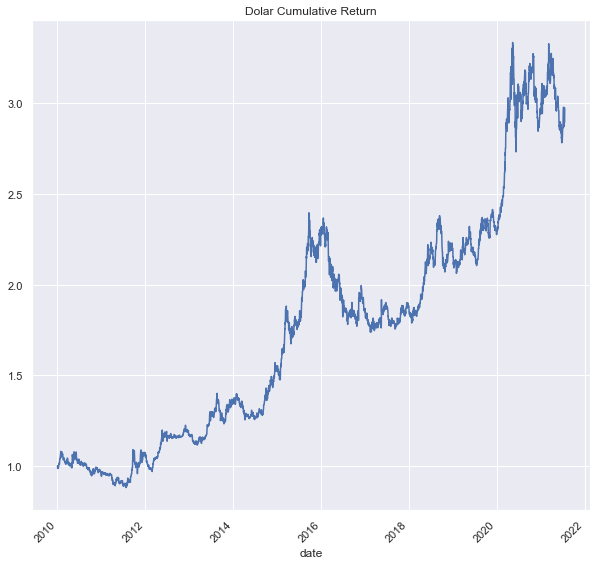

In [40]:
plot_cum_return('Dolar', dolar)

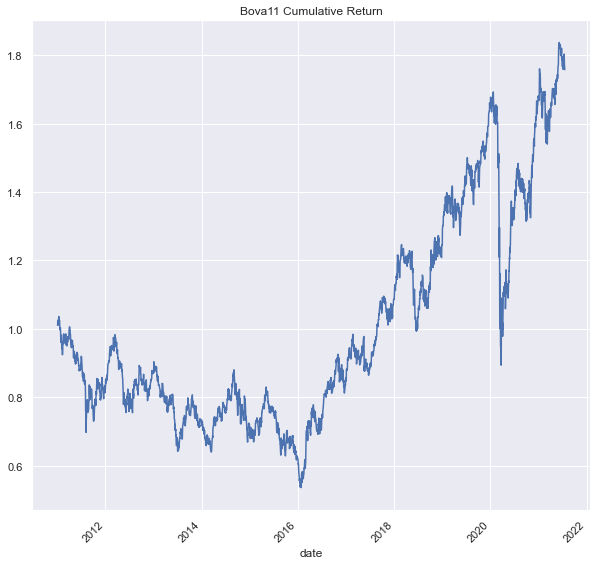

In [41]:
plot_cum_return('Bova11', bova11)

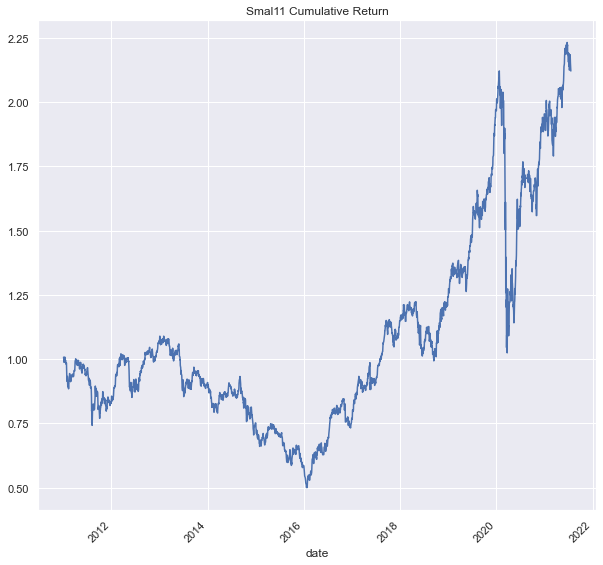

In [42]:
plot_cum_return('Smal11', smal11)

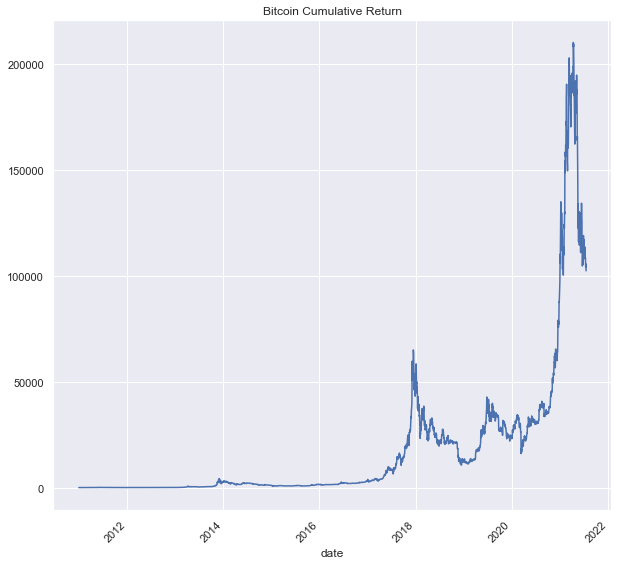

In [43]:
plot_cum_return('Bitcoin', bitcoin)

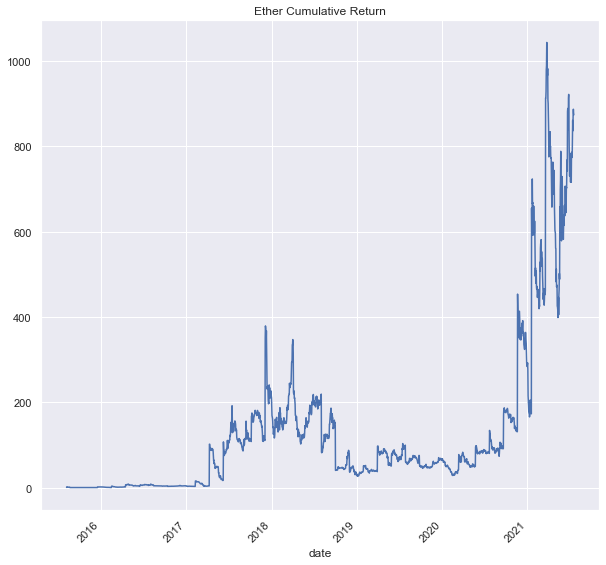

In [44]:
plot_cum_return('Ether', ether)

Algumas observações: ao final do período, todos ativos obtiveram valorização. No entanto, vale a pena destacar o percusso: o **Bova11** e o **Small1** foram os ativos que mais sofreram retornos negativos, sobretudo ao longo da crise de 2014-2016, provavelmente devido ao caráter e ao vínculo com a economia nacional desses índices, além do impacto da crise do Covid-19 deflagrada em 2020;


O **Bitcoin** e o **Ether** são disparadamente as que mais alcançaram valorização acumulada, demonstrando o poder crescente das criptomoeadas. Esses dois ativos basicamente não sofreram com o impacto da pandemia, junto ao **dólar** que, devido à evasão de agentes econômicos nesse período, valorizou-se.

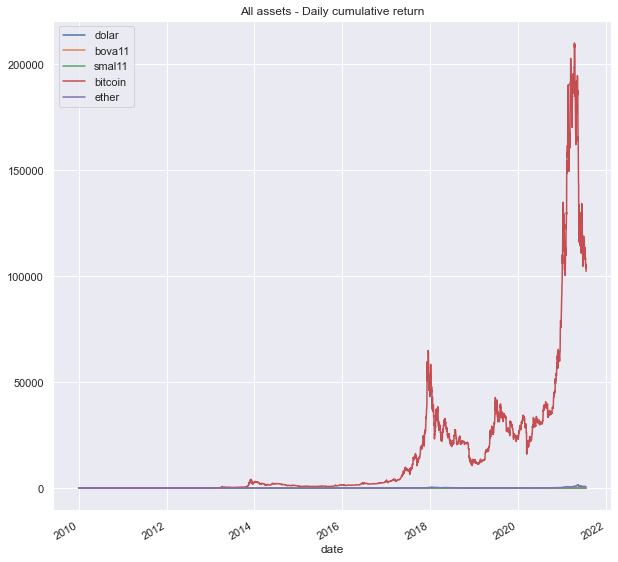

In [45]:
(1+full_return_pct).cumprod().plot();
plt.title('All assets - Daily cumulative return');

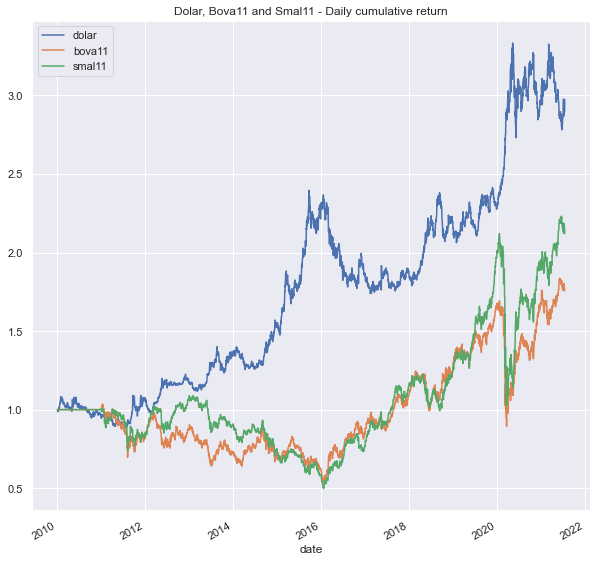

In [46]:
(1+full_return_pct.drop(['bitcoin', 'ether'], axis=1)).cumprod().plot()
plt.title('Dolar, Bova11 and Smal11 - Daily cumulative return');

#### Daily Return Cumulative Sum per Day of the Year --> Sazonalidade

In [47]:
def plot_cumsum_day_of_year(asset_name, df):
    plt.title('{} - Daily Return Cumulative Sum per Day of the Year'.format(asset_name))
    (1+df.groupby(df.index.day_of_year)['daily_return_pct'].mean()).cumprod().plot()
    return plt.show()

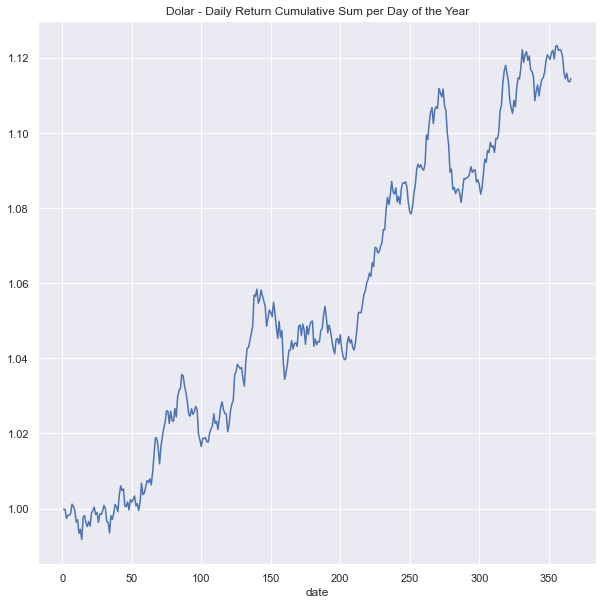

In [48]:
plot_cumreturn_day_of_year('Dolar', dolar)

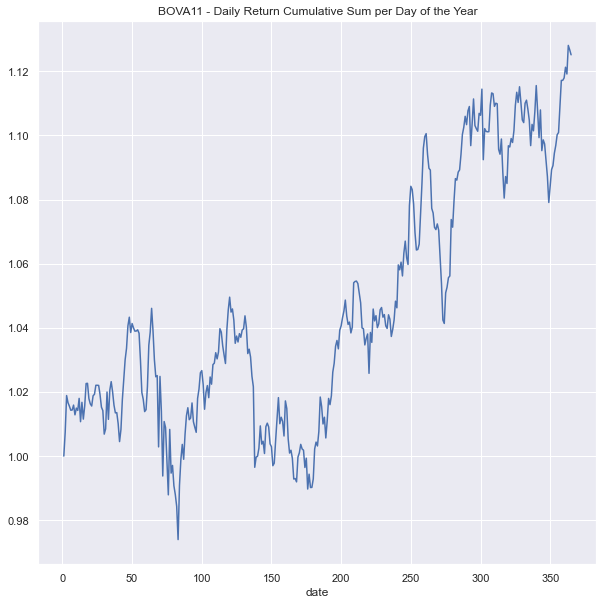

In [49]:
plot_cumreturn_day_of_year('BOVA11', bova11)

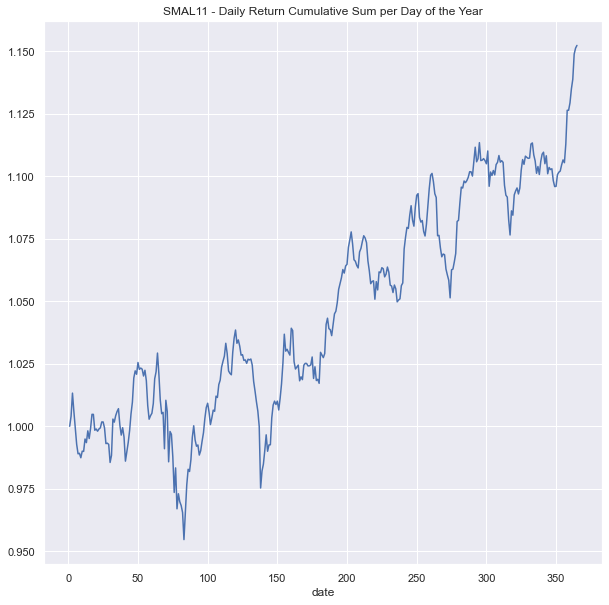

In [50]:
plot_cumreturn_day_of_year('SMAL11', smal11)

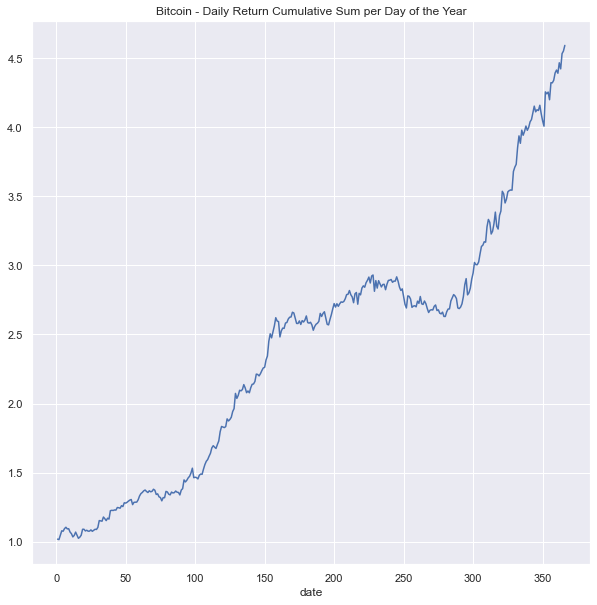

In [51]:
plot_cumreturn_day_of_year('Bitcoin', bitcoin)

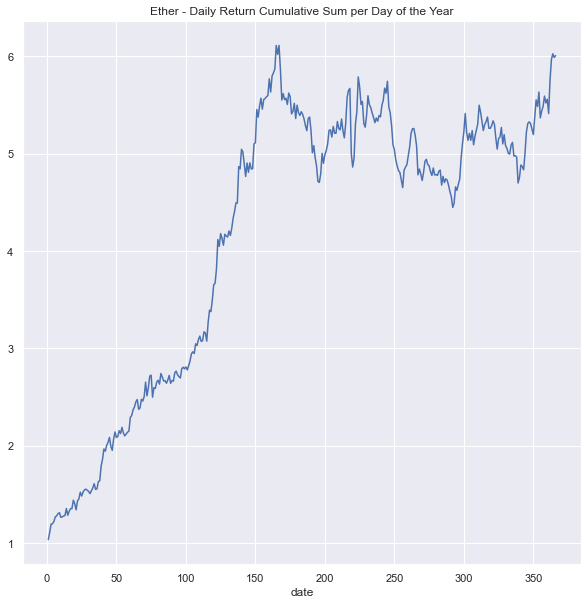

In [52]:
plot_cumreturn_day_of_year('Ether', ether)

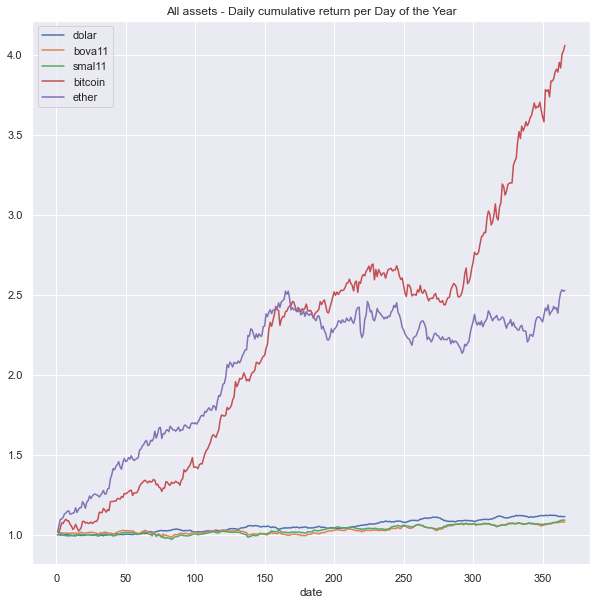

In [53]:
(1+full_return_pct.groupby(full_return_pct.index.day_of_year).mean()).cumprod().plot();
plt.title('All assets - Daily cumulative return per Day of the Year');

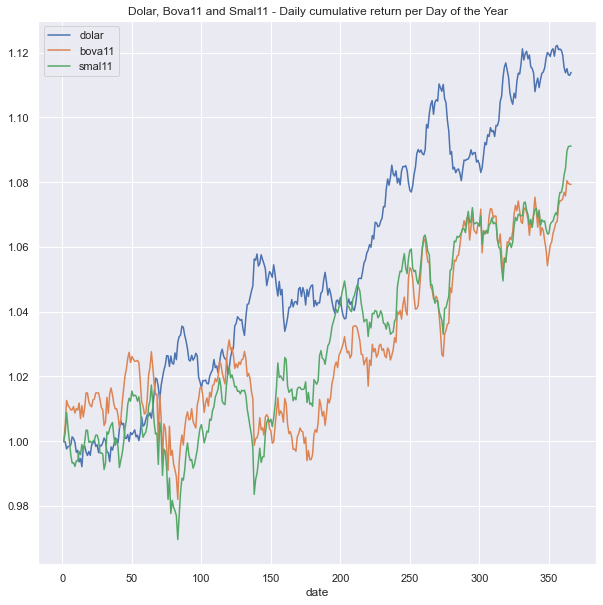

In [54]:
(1+full_return_pct[['dolar', 'bova11', 'smal11']].groupby(full_return_pct[['dolar', 'bova11', 'smal11']].index.day_of_year).mean()).cumprod().plot();
plt.title('Dolar, Bova11 and Smal11 - Daily cumulative return per Day of the Year');

De forma geral, a maioria dos ativos tende a iniciar o ano num ritmo mais lento ao passo que vão aumento a geração de retorno diário ao longo do ano. 

Percebemos novamente como o desenvolvimento de Bitcoin e Ether distorce a comparação, devido ao seu acentuado acúmulo. Retirando-los, pode-se identificar como a dinâmica de movimento do Dólar é on reflexo oposto do movimento do **Bova11** e **Smal11**. Ademais, Bova11 e o Smal11 apresentam solavancos negativos ao longo do ano sobretudo entre o primeiro trimestre e o segundo trimestre dos anos. Vale ressaltar que esses desempenhos provavelmente foram influenciados pelo pandemia do Covid-19 que impactou fortemente a economia brasileira nesse período.

####  Mean Daily Return Percentage per Month-> Sazonalidade

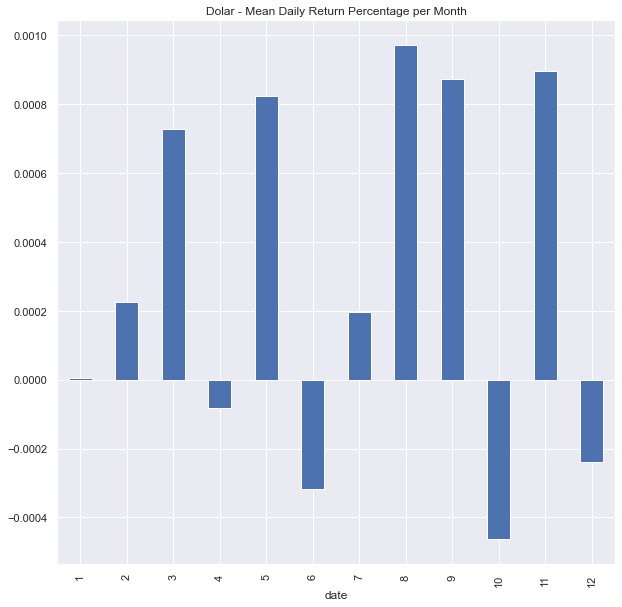

In [55]:
plot_mean_month('Dolar',dolar)

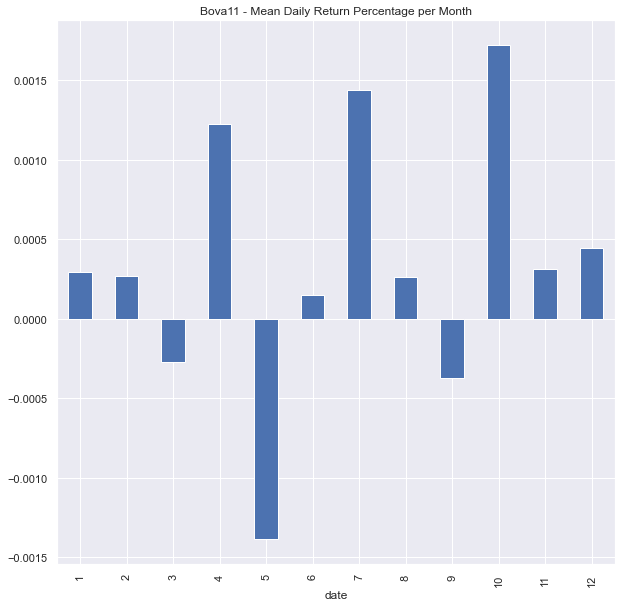

In [56]:
plot_mean_month('Bova11', bova11)

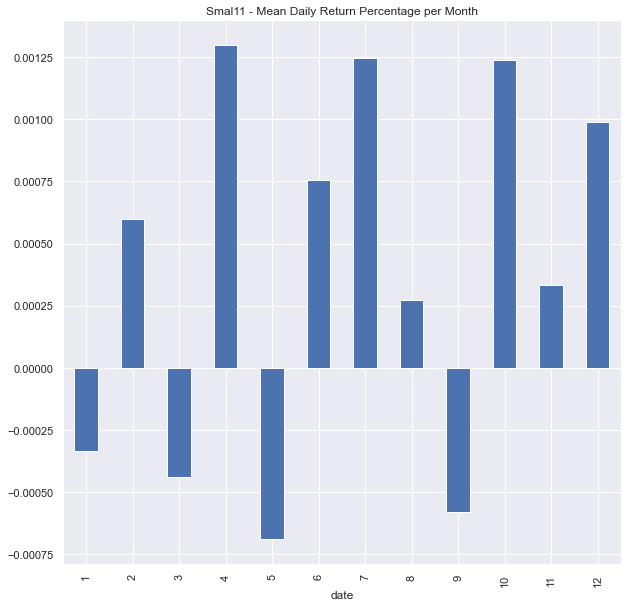

In [57]:
plot_mean_month('Smal11', smal11)

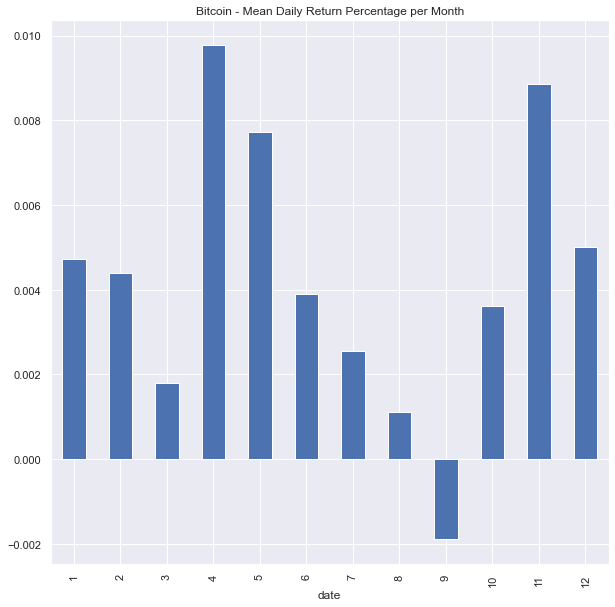

In [58]:
plot_mean_month('Bitcoin', bitcoin)

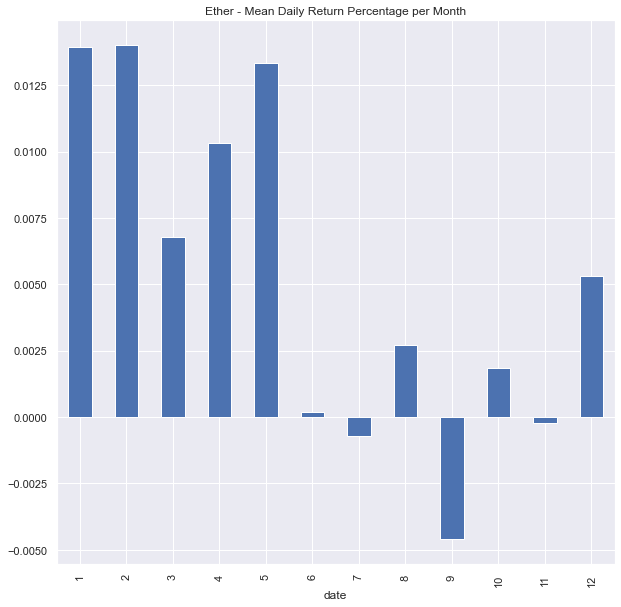

In [59]:
plot_mean_month('Ether', ether)

Como é possível observar,o mês de **Setembro** foi um mês de retornos negativos para 4 dos 5 ativos. Para certificarmos de que não se trata de valores discrepantes (outliers), vamos visualizar mais afundos esse mês específico.

#### Daily Return Percentage Sum per Day of Month - May and September

**Negative Returns**

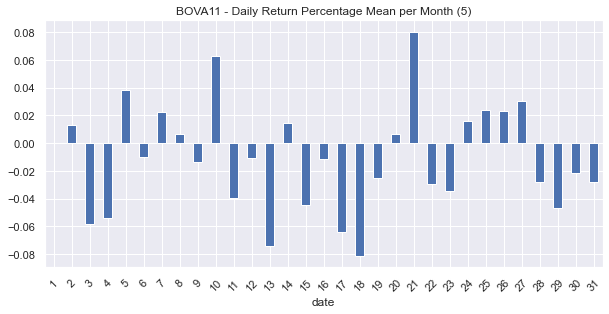

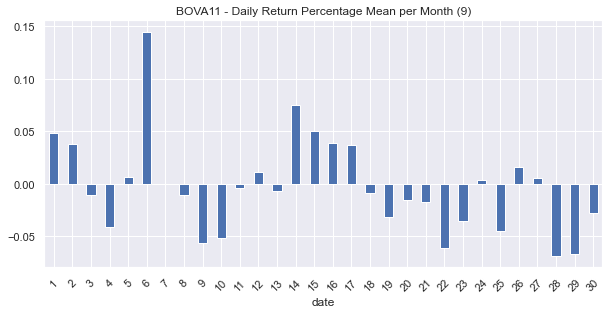

In [60]:
plt.subplot(2,1,1)
plot_daily_sum_per_month('BOVA11', bova11, 5)

plt.subplot(2,1,2)
plot_daily_sum_per_month('BOVA11', bova11, 9)


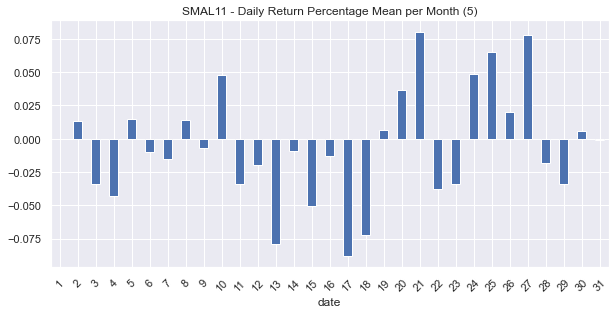

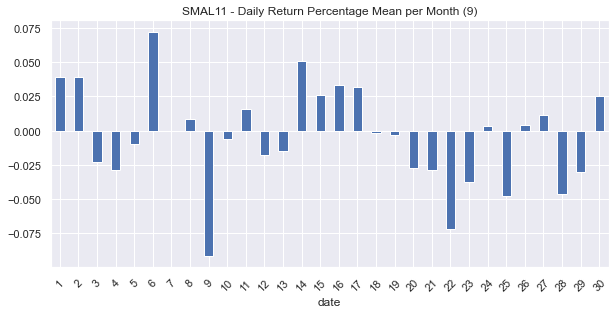

In [61]:
plt.subplot(2,1,1)
plot_daily_sum_per_month('SMAL11', smal11, 5)

plt.subplot(2,1,2)
plot_daily_sum_per_month('SMAL11', smal11, 9)


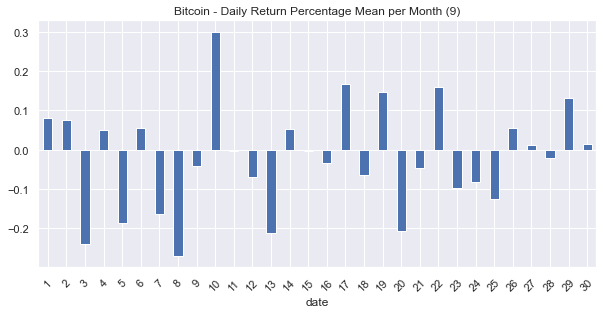

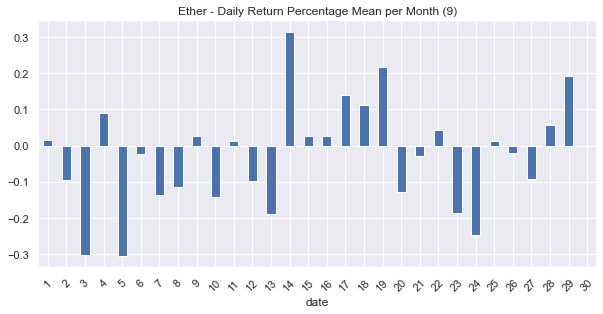

In [62]:
# Bitcoin and Ether both in September
plt.subplot(2,1,1)
plot_daily_sum_per_month('Bitcoin', bitcoin, 9)

plt.subplot(2,1,2)
plot_daily_sum_per_month('Ether', ether, 9)


Podemos observar que realmente Setembro possui um comportamento atípico em termos de rentabilidade, **não se tratando, portanto, de outlier**. A explicação para esse fenômeno requer um maior entendimento da dinâmica desses ativos, em específico, e do mercado, em geral, ao longo desse período.

Se para valores negativos tentamos verificar a presença de outliers, faremos o mesmo para os retornos positivos. Na seção seguinte, usamos a **mediana**, ao invés da média, para conferir a performance dos ativos **sem a possível influência de valores discrepantes**.

####  Median Daily Return Percentage per Month

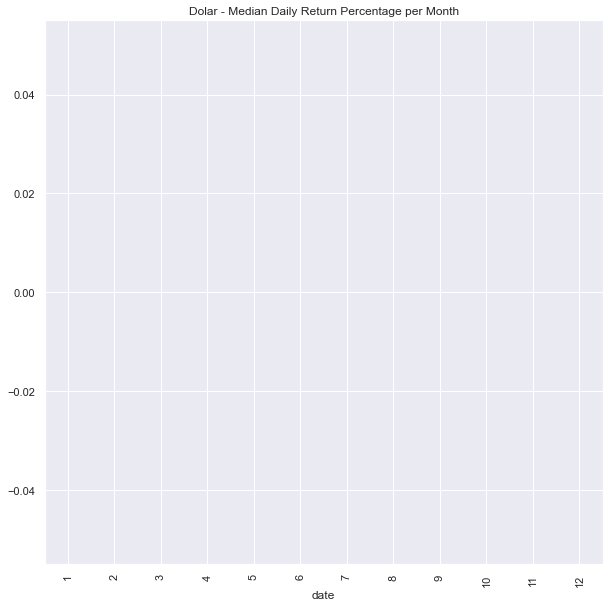

In [63]:
# The Dolar's Median Daily Return Percentage per Month is 0 for all months
plot_median_month('Dolar',dolar)

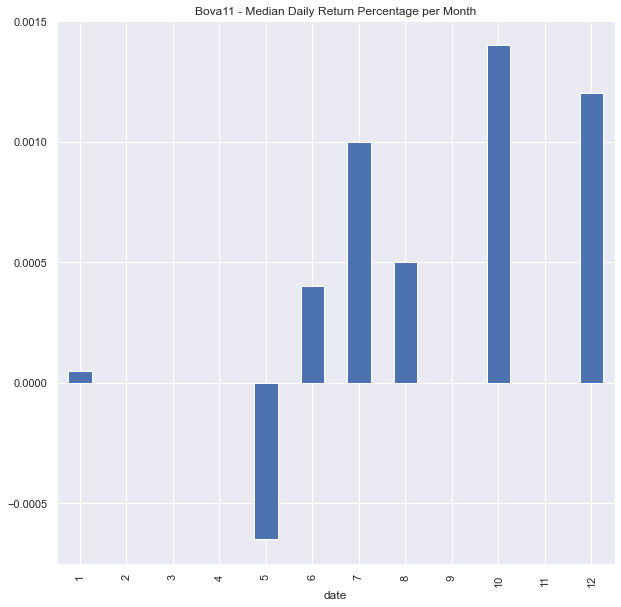

In [64]:
plot_median_month('Bova11',bova11)

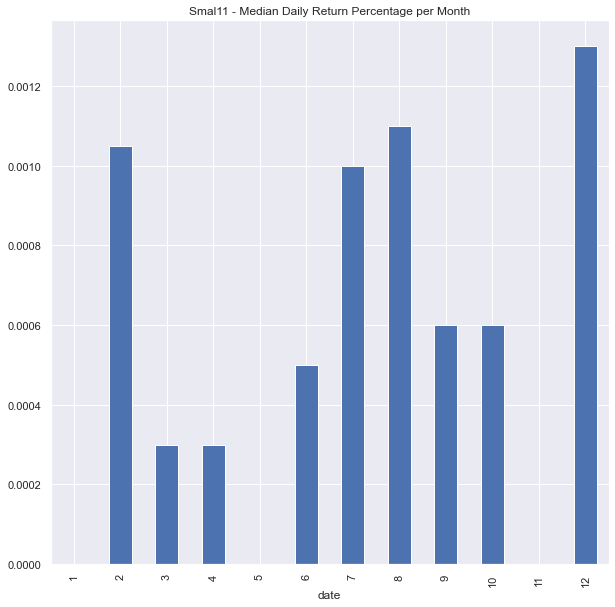

In [65]:
plot_median_month('Smal11',smal11)

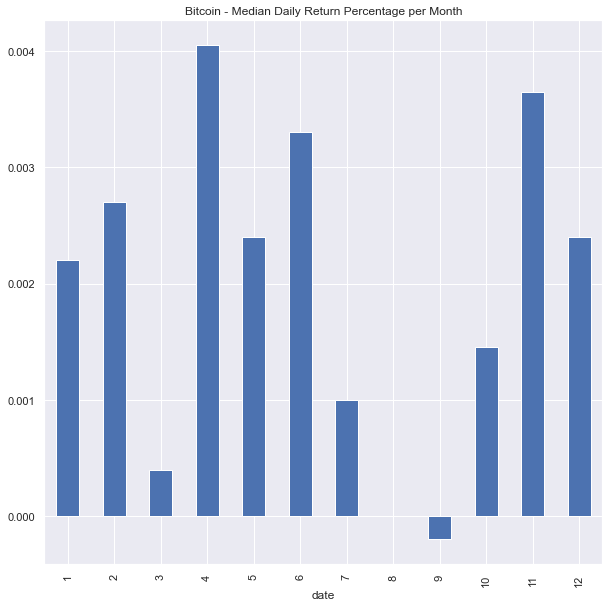

In [66]:
plot_median_month('Bitcoin', bitcoin)

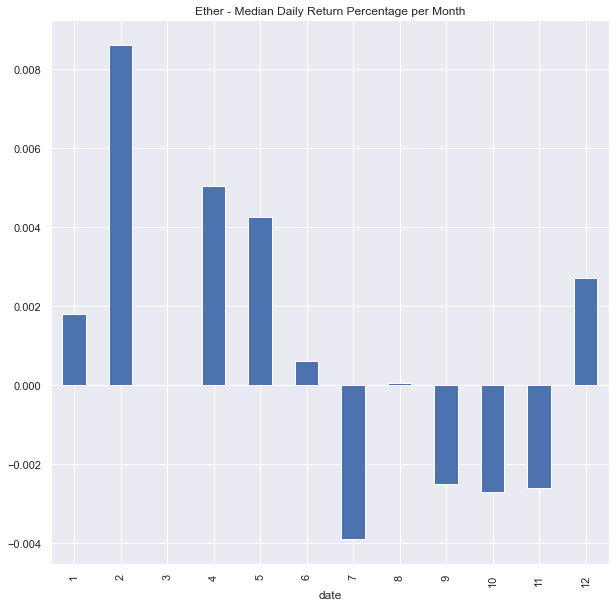

In [67]:
plot_median_month('Ether',ether)

O que vale ser destacado é como há presença significativa de variação nula em alguns meses, com destaque extraordinário do dólar. No mais, **a tendência das medianax mais ou menos reflete a tendência das médias**, principalmente no caso das criptomoedas, como pode ser visto no caso dos meses de retorno baixo do **Bitcoin** e do segundo semestre fraco do **Ether**.

In [68]:
# rows=2
# columns=2
# plt.subplot(rows,columns,1)
# plot_cumsum_day_of_year('Dolar', dolar)

# plt.subplot(rows,columns,2)
# plot_cumsum_day_of_year('BOVA11', bova11)

# plt.subplot(rows,columns,3)
# plot_cumsum_day_of_year('SMAL11', smal11)

# plt.subplot(rows,columns,4)
# plot_cumsum_day_of_year('Bitcoin', bitcoin)

# # plt.subplot(rows,columns,5)
# # plot_cumsum_day_of_year('Ether', ether)
# plt. subplots_adjust()

#### Yearly Return

In [69]:
dolar.daily_return_pct.mean()

0.00029845597104945714

In [70]:
#def yearly_
dolar.groupby(dolar.index.year)['daily_return_pct'].mean()*252

date
2010   -0.02791
2011    0.08889
2012    0.07103
2013    0.10380
2014    0.08761
2015    0.29247
2016   -0.13108
2017    0.01913
2018    0.11635
2019    0.03034
2020    0.20822
2021    0.02681
Name: daily_return_pct, dtype: float64

#### Short and Long Moving Average

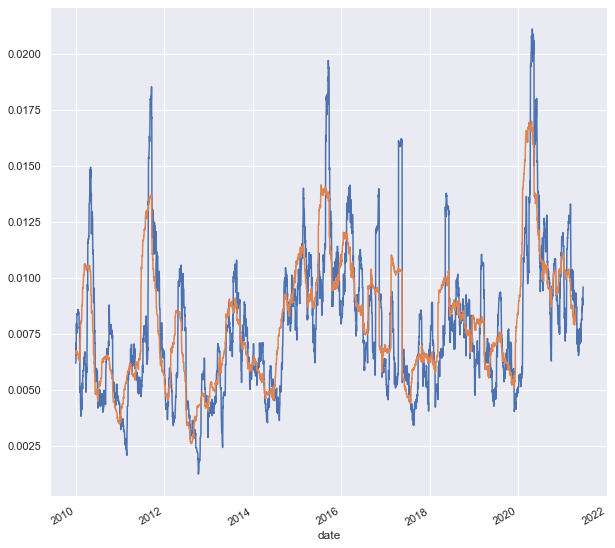

In [71]:
dolar.daily_return_pct.rolling(window=30).std().plot();
dolar.daily_return_pct.rolling(window=90).std().plot();


####

* Histograma
* **Média móvel** curta (30 dias) e longa (90 dias): `daily_return_pct.rolling(windows=30).mean()` => Plotar `.plot()`
    * Ver comportamentos e tendência
* **Volatilidade**: desvio padrão => quanto maior a amplitude da distribuição (histograma), maior a volatilidade e, portanto, maior o risco.
    * Criar a **média móvel da volatilidade**: `daily_return_pct.rolling(windows=30).std()` e plotar `.plot()`
* Normalização dos preços: a forma de comparar ativos de preços diferentes
    * `retorno_acumulado = (1 + df.daily_return_pct).cumprod()`

#### Volatility

Dolar Standard Deviation: 0.00844


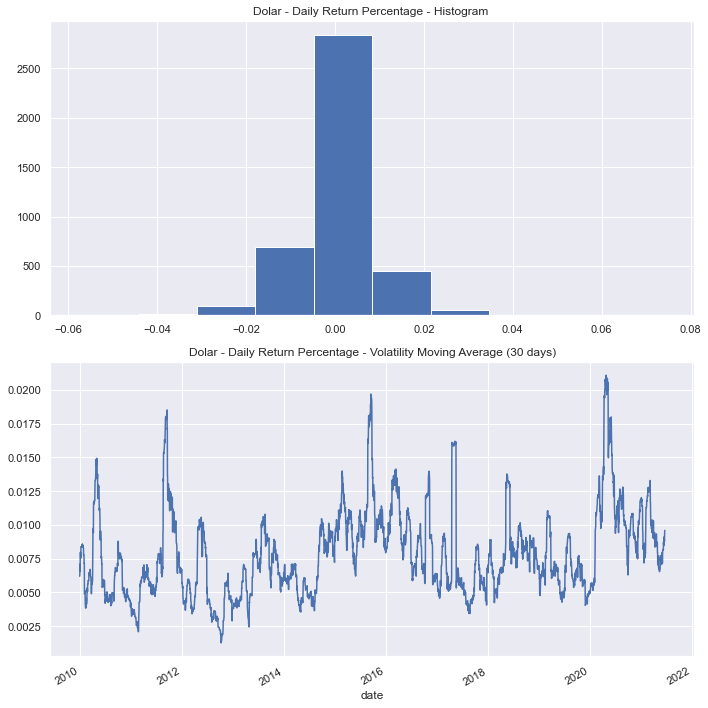

In [72]:
plot_volatility('Dolar',dolar)

Bova11 Standard Deviation: 0.01578


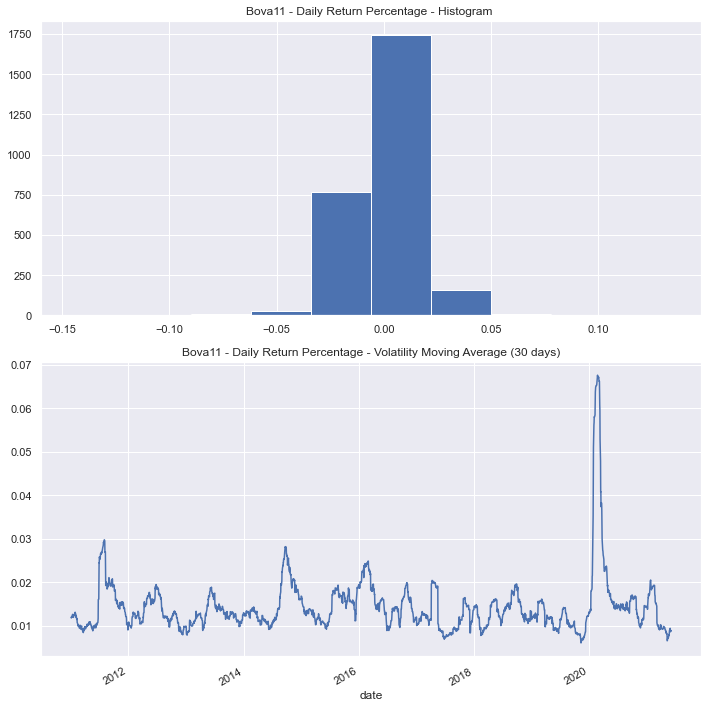

In [73]:
plot_volatility('Bova11',bova11)

Smal11 Standard Deviation: 0.01424


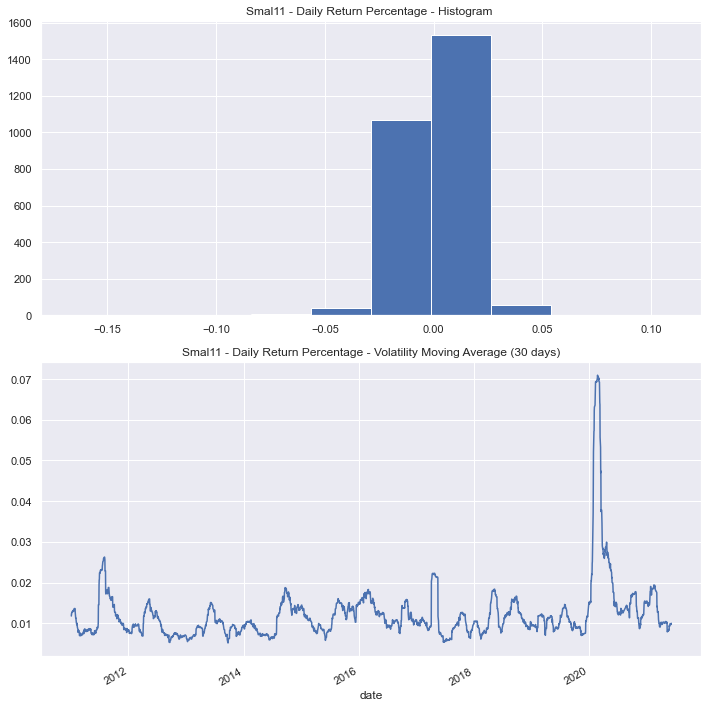

In [74]:
plot_volatility('Smal11',smal11)

Bitcoin Standard Deviation: 0.05186


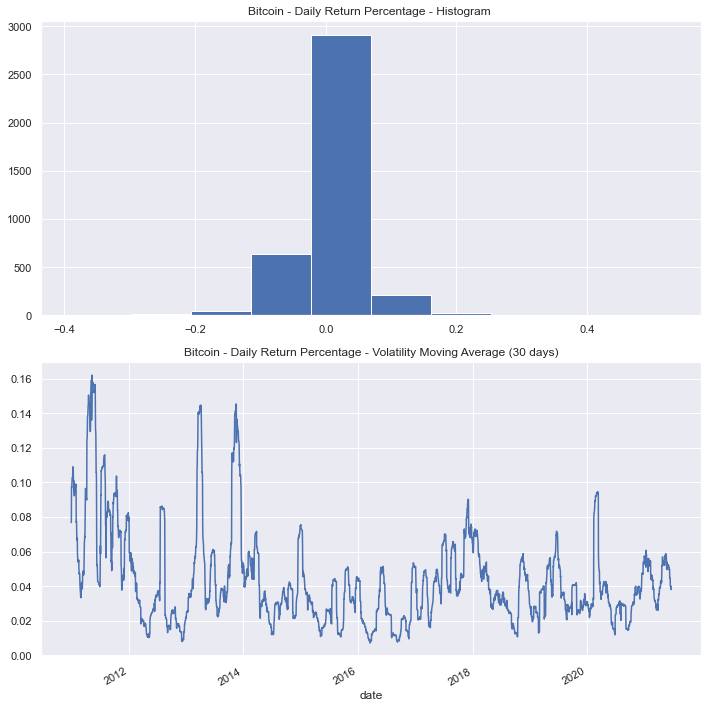

In [75]:
plot_volatility('Bitcoin',bitcoin)

Ether Standard Deviation: 0.06571


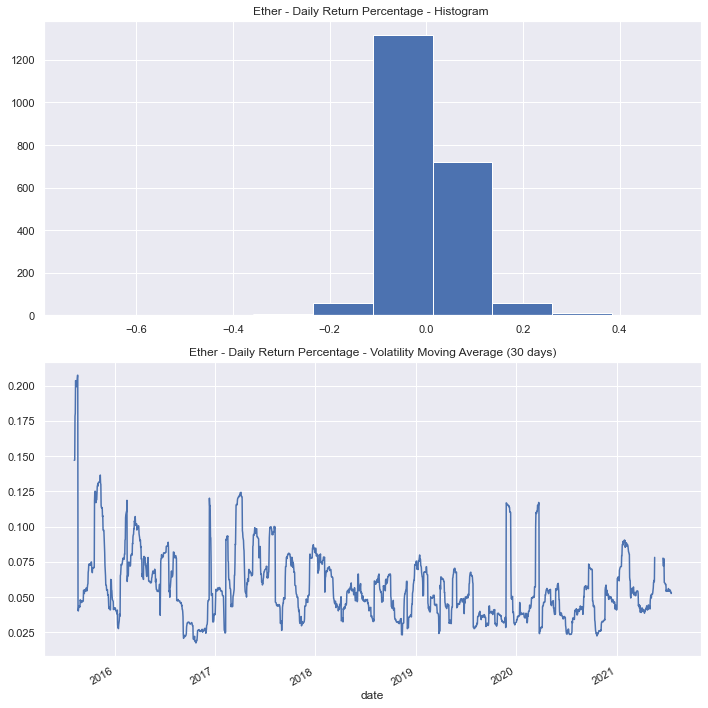

In [76]:
plot_volatility('Ether',ether)

#### Mean-Variance 

In [77]:
mean_std = pd.DataFrame()
mean_std['mean'] = [full_return_pct[column].mean() for column in full_return_pct.columns]
mean_std['std'] =[full_return_pct[column].std() for column in full_return_pct.columns]
mean_std.set_index(full_return_pct.columns, inplace=True)
mean_std

mean     std
dolar   0.00029 0.00837
bova11  0.00021 0.01268
smal11  0.00024 0.01143
bitcoin 0.00396 0.04957
ether   0.00271 0.04725

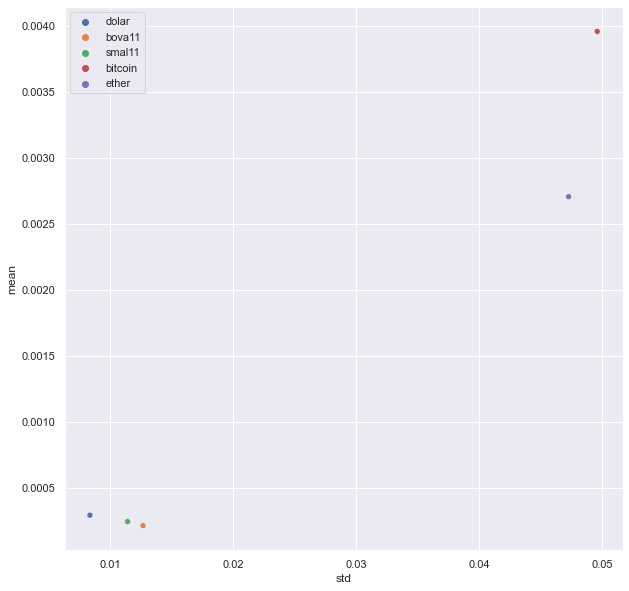

In [78]:
sns.scatterplot(mean_std['std'],mean_std['mean'],hue=mean_std.index);

## 4.2 Bivariate Analysis

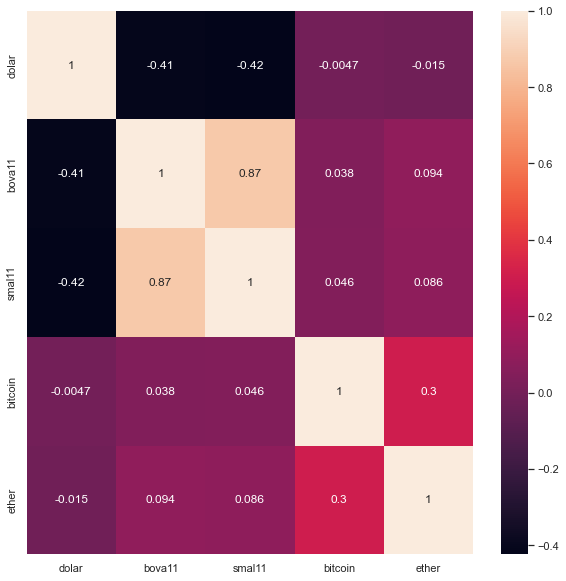

In [79]:
daily_corr = full_return_pct.corr()
sns.heatmap(daily_corr, annot=True);

#### Covariance

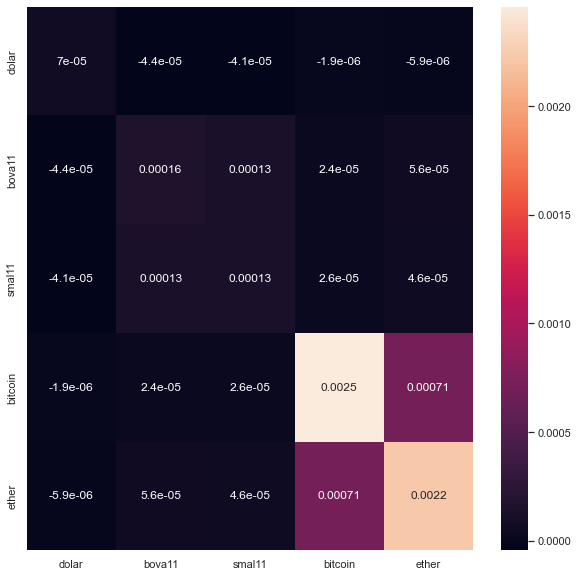

In [80]:
daily_cov = full_return_pct.cov()
sns.heatmap(daily_cov, annot=True);

## 4.3 Multivariate Analysis - Hypothesis Testing

Para geração e validação de hipóteses, iremos criar um cenário fictício por meio de perfis de investimentos diferentes, conforme nossa cartela de ativos, afim de levantar insights sobre a performance dessas aplicações em termos de retorno (`daily_return_pct`) e de risco (`std`).

A ideia é utilizar a **Simulação de Monte Carlo** para validar nossas hipóteses, de modo a testar a alocação de investimento das carteiras dde investimento, que correspondem ao perfil de investidor criado. A Simulação de Monte Carlo contribui para criar portfólios com combinações alocação (aleaórias ou não), levando em conta a covariância entre os ativos do portfólio. Com a Simulação de Monte Carlo, por exemplo, é possível criar uma carteira de ativos cujo risco é menor do que todos os ativos separadamente.

Perfis de investidores e sua correspondente porcentagem de alocação:
* **Investidor Nacional**: Bova11 (50%) e Smal11 (50%)
* **Investidor de criptomoeda**: Bitcoin (50%) e Ether (50%)
* **Investidor Estrangeiro**: Dolar (40%), Ether (30%) e Bova11 (30%)

**Hipóteses**:
1. O investidor de criptomoeda terá o dobro do retorno do investidor nacional
2. Investidor nacional terá um rendimento médio maisor do que o estrangeiro
3. O risco do investidor de cripto é maior do que a soma do risco dos investidores nacional e estrangeiro
4. Investir só em dólar dá um retorno médio maior do que o retorno do investidor nacional
5. O retorno médio do investidor estrangeiro é maior do que o retorno médio do investidor de criptomoeda
6. Investir 20% em cada ativo dá um retorno maior do que só investir em ativos nacionais 

### 4.3.1 Monte Carlo Simulation - Hypothesis Validation

In [81]:
port = hyp_monte_carlo(full_return_pct)
port

returns  volatility  return_risk_ratio  dolar_weight  bova11_weight  smal11_weight  bitcoin_weight  ether_weight invest_profile
0  0.05789     0.18500            0.31292       0.00000        0.50000        0.50000         0.00000       0.00000       National
1  0.83952     0.62007            1.35391       0.00000        0.00000        0.00000         0.50000       0.50000         Crypto
2  0.25037     0.23803            1.05182       0.40000        0.30000        0.00000         0.00000       0.30000        Foreign
3  0.07396     0.13290            0.55654       1.00000        0.00000        0.00000         0.00000       0.00000     Dolar_Only
4  0.37376     0.26253            1.42366       0.20000        0.20000        0.20000         0.20000       0.20000       Balanced

**1. O investidor de criptomoeda terá o dobro do retorno do investidor nacional**

In [82]:
print('Verdadeiro, o Investidor de criptomoeda obteve mais que {}x o retorno do investidor nacional.'.format(np.round(float(port.loc[port.invest_profile =='Crypto']['returns'].values / port.loc[port.invest_profile =='National']['returns'].values),2)))

Verdadeiro, o Investidor de criptomoeda obteve mais que 14.5x o retorno do investidor nacional.


**2. Investidor nacional terá um rendimento médio maior do que o estrangeiro**

In [83]:
print('Falso, a rentabilidade do investido estrangeiro ({}) é significativamente maior do que o do investidor nacional ({}).'.format(round(float(port.loc[port.invest_profile =='Foreign']['returns'].values),3),round(float(port.loc[port.invest_profile =='National']['returns'].values),3)))

Falso, a rentabilidade do investido estrangeiro (0.25) é significativamente maior do que o do investidor nacional (0.058).


**3. O risco do investidor de cripto é maior do que a soma do risco dos investidores nacional e estrangeiro**

In [84]:
print('Verdadeiro, o risco do investidor de criptomoedade ({}) é maior do que a soma dos riscos dos investidores nacional e estrangeiro ({}).'.format(round(float(port.loc[port.invest_profile =='Crypto']['volatility'].values),3),
                                                                                                                                                 round(float(port.loc[port.invest_profile =='National']['volatility'].values),3) + round(float(port.loc[port.invest_profile =='Foreign']['volatility'].values),3)))

Verdadeiro, o risco do investidor de criptomoedade (0.62) é maior do que a soma dos riscos dos investidores nacional e estrangeiro (0.423).


**4. Investir só em dólar rendeu um retorno médio maior do que o retorno do investidor nacional**

In [85]:
print('Verdadeiro, a compra e venda de dólares rendeu um retorno maior ({}) do que as aplicações do investidor nacional ({})'.format(round(float(port.loc[port.invest_profile =='Dolar_Only']['returns'].values),3),
                                                                                                                                round(float(port.loc[port.invest_profile =='National']['returns'].values),3)))

Verdadeiro, a compra e venda de dólares rendeu um retorno maior (0.074) do que as aplicações do investidor nacional (0.058)


**5. O retorno médio do investidor estrangeiro é maior do que o retorno médio do investidor de criptomoeda**


In [86]:
print('Falso, a rentabildiade auferida pelo investido de criptomoeda ({}) é significativamente maior do que a do investidor estrangeiro ({}).'.format(round(float(port.loc[port.invest_profile =='Crypto']['returns'].values),3),
                                                                                                                                                     round(float(port.loc[port.invest_profile =='Foreign']['returns'].values),3)))

Falso, a rentabildiade auferida pelo investido de criptomoeda (0.84) é significativamente maior do que a do investidor estrangeiro (0.25).


**6. Investir 20% em cada ativo dá um retorno maior do que só investir em ativos nacionais**

In [87]:
print('Verdadeiro, o investimento balanceado na carteira de ativos aufere uma rentabilidade ({}) consideravelmente maior do que a carteira exclusivamente nacional ({}).'.format(round(float(port.loc[port.invest_profile =='Balanced']['returns'].values),3),
                                                                                                                                                                                 round(float(port.loc[port.invest_profile =='National']['returns'].values),3)))

Verdadeiro, o investimento balanceado na carteira de ativos aufere uma rentabilidade (0.374) consideravelmente maior do que a carteira exclusivamente nacional (0.058).


# 5.0 Data Preparation

In [88]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

In [89]:
# Min Max Scaler
mms = MinMaxScaler()

In [90]:
for df in [dolar_full]:
    df['close'] = mms.fit_transform(df[['close']].values)
    df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
    df['open'] = mms.fit_transform(df[['open']].values)
    df['high'] = mms.fit_transform(df[['high']].values)
    df['low'] = mms.fit_transform(df[['low']].values)
    df['volume'] = mms.fit_transform(df[['volume']].values)
    df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
    df['ipca'] = mms.fit_transform(df[['ipca']].values)
    df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
    df['bova11'] = mms.fit_transform(df[['bova11']].values)
    df['smal11'] = mms.fit_transform(df[['smal11']].values)
    df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
    df['ether'] = mms.fit_transform(df[['ether']].values)
dolar_full.head()

close  daily_variation  daily_return_pct    open    high     low  volume symbol  taxa_selic    ipca  indice_di  bova11  smal11  bitcoin   ether
date                                                                                                                                                        
2021-07-19 0.85389          0.66102           0.02680 0.82273 0.83853 0.82823 0.00000  DOLAR     0.12245 0.52601    0.16667 0.49303 0.55346  0.39049 0.55459
2021-07-18 0.82241          0.42373           0.00000 0.82248 0.80631 0.82874 0.00000  DOLAR     0.12245 0.52601    0.16667 0.48302 0.57485  0.43555 0.59288
2021-07-17 0.82241          0.42373           0.00000 0.82125 0.80626 0.82755 0.00000  DOLAR     0.12245 0.52601    0.16667 0.48302 0.57485  0.42968 0.59798
2021-07-16 0.82240          0.42373           0.00080 0.82158 0.80882 0.81954 0.00000  DOLAR     0.12245 0.52601    0.16667 0.48302 0.57485  0.41759 0.57879
2021-07-15 0.82149          0.49153           0.00790 0.81238 0.81146 0.81505 0.00000  DOLAR     0.12245 0.52601    0.16667 0.49553 0.57738  0.38482 0.55330

In [91]:
for df in [bova11_full]:
    df['close'] = mms.fit_transform(df[['close']].values)
    df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
    df['open'] = mms.fit_transform(df[['open']].values)
    df['high'] = mms.fit_transform(df[['high']].values)
    df['low'] = mms.fit_transform(df[['low']].values)
    df['volume'] = mms.fit_transform(df[['volume']].values)
    df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
    df['ipca'] = mms.fit_transform(df[['ipca']].values)
    df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
    df['dolar'] = mms.fit_transform(df[['dolar']].values)
    df['smal11'] = mms.fit_transform(df[['smal11']].values)
    df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
    df['ether'] = mms.fit_transform(df[['ether']].values)
bova11_full.head()

close  daily_variation  daily_return_pct    open    high     low  volume  symbol  taxa_selic    ipca  indice_di   dolar  smal11  bitcoin   ether
date                                                                                                                                                         
2011-01-03 0.36752          0.59344           0.01040 0.36616 0.36927 0.37114 0.00382  BOVA11     0.75673 0.68208    0.65741 0.38146 0.63211  0.43860 0.00000
2011-01-04 0.37267          0.58173           0.00660 0.35944 0.36927 0.36516 0.01032  BOVA11     0.75673 0.68208    0.65741 0.50076 0.58028  0.42456 0.00000
2011-01-05 0.37884          0.58595           0.00790 0.37367 0.37619 0.37193 0.00668  BOVA11     0.75673 0.68208    0.65741 0.49088 0.59986  0.42064 0.00000
2011-01-06 0.37211          0.53208          -0.00850 0.38185 0.37708 0.37869 0.00619  BOVA11     0.75673 0.68208    0.65741 0.49088 0.58209  0.50457 0.00000
2011-01-07 0.36853          0.54520          -0.00460 0.37457 0.37217 0.37182 0.00473  BOVA11     0.75673 0.68208    0.65741 0.42705 0.57956  0.43414 0.00000

In [92]:
for df in [smal11_full]:
    df['close'] = mms.fit_transform(df[['close']].values)
    df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
    df['open'] = mms.fit_transform(df[['open']].values)
    df['high'] = mms.fit_transform(df[['high']].values)
    df['low'] = mms.fit_transform(df[['low']].values)
    df['volume'] = mms.fit_transform(df[['volume']].values)
    df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
    df['ipca'] = mms.fit_transform(df[['ipca']].values)
    df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
    df['dolar'] = mms.fit_transform(df[['dolar']].values)
    df['bova11'] = mms.fit_transform(df[['bova11']].values)
    df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
    df['ether'] = mms.fit_transform(df[['ether']].values)
smal11_full.head()

close  daily_variation  daily_return_pct    open    high     low  volume  symbol  taxa_selic    ipca  indice_di   dolar  bova11  bitcoin   ether
date                                                                                                                                                         
2011-01-03 0.36752          0.59344           0.01040 0.36616 0.36927 0.37114 0.00382  BOVA11     0.75673 0.68208    0.65741 0.38146 0.55810  0.43860 0.00000
2011-01-04 0.37267          0.58173           0.00660 0.35944 0.36927 0.36516 0.01032  BOVA11     0.75673 0.68208    0.65741 0.50076 0.54451  0.42456 0.00000
2011-01-05 0.37884          0.58595           0.00790 0.37367 0.37619 0.37193 0.00668  BOVA11     0.75673 0.68208    0.65741 0.49088 0.54916  0.42064 0.00000
2011-01-06 0.37211          0.53208          -0.00850 0.38185 0.37708 0.37869 0.00619  BOVA11     0.75673 0.68208    0.65741 0.49088 0.49053  0.50457 0.00000
2011-01-07 0.36853          0.54520          -0.00460 0.37457 0.37217 0.37182 0.00473  BOVA11     0.75673 0.68208    0.65741 0.42705 0.50447  0.43414 0.00000

In [93]:
for df in [bitcoin_full]:
    df['close'] = mms.fit_transform(df[['close']].values)
    df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
    df['open'] = mms.fit_transform(df[['open']].values)
    df['high'] = mms.fit_transform(df[['high']].values)
    df['low'] = mms.fit_transform(df[['low']].values)
    df['volume'] = mms.fit_transform(df[['volume']].values)
    df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
    df['ipca'] = mms.fit_transform(df[['ipca']].values)
    df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
    df['dolar'] = mms.fit_transform(df[['dolar']].values)
    df['bova11'] = mms.fit_transform(df[['bova11']].values)
    df['smal11'] = mms.fit_transform(df[['smal11']].values)
    df['ether'] = mms.fit_transform(df[['ether']].values)
bitcoin_full.head()

close  daily_variation  daily_return_pct    open    high     low  volume   symbol  taxa_selic    ipca  indice_di   dolar  bova11  smal11   ether
date                                                                                                                                                         
2010-12-31 0.00000          0.44227           0.00000 0.00000 0.00000 0.00000 0.00000  BITCOIN     0.75673 0.69942    0.67593 0.43161 0.55810 0.63211 0.00000
2011-01-01 0.00000          0.44227           0.00000 0.00000 0.00000 0.00000 0.00000  BITCOIN     0.75673 0.69942    0.67593 0.43617 0.55810 0.63211 0.00000
2011-01-02 0.00000          0.44227          -0.01670 0.00000 0.00000 0.00000 0.00000  BITCOIN     0.75673 0.69942    0.67593 0.43617 0.55810 0.63211 0.00000
2011-01-03 0.00000          0.44227           0.01320 0.00000 0.00000 0.00000 0.00000  BITCOIN     0.75673 0.69942    0.67593 0.38146 0.55810 0.63211 0.00000
2011-01-04 0.00000          0.44227           0.00030 0.00000 0.00000 0.00000 0.00000  BITCOIN     0.75673 0.69942    0.67593 0.50076 0.54451 0.58028 0.00000

In [94]:
for df in [ether_full]:
    df['close'] = mms.fit_transform(df[['close']].values)
    df['daily_variation'] = mms.fit_transform(df[['daily_variation']].values)
    df['open'] = mms.fit_transform(df[['open']].values)
    df['high'] = mms.fit_transform(df[['high']].values)
    df['low'] = mms.fit_transform(df[['low']].values)
    df['volume'] = mms.fit_transform(df[['volume']].values)
    df['taxa_selic'] = mms.fit_transform(df[['taxa_selic']].values)
    df['ipca'] = mms.fit_transform(df[['ipca']].values)
    df['indice_di'] = mms.fit_transform(df[['indice_di']].values)
    df['dolar'] = mms.fit_transform(df[['dolar']].values)
    df['bova11'] = mms.fit_transform(df[['bova11']].values)
    df['smal11'] = mms.fit_transform(df[['smal11']].values)
    df['bitcoin'] = mms.fit_transform(df[['bitcoin']].values)
ether_full.head()

close  daily_variation  daily_return_pct    open    high     low  volume symbol  taxa_selic    ipca  indice_di   dolar  bova11  smal11  bitcoin
date                                                                                                                                                        
2015-08-07 0.00008          0.61993          -0.72820 0.00067 0.00064 0.00018 0.00286  ETHER     1.00000 0.53179    0.90741 0.43617 0.41115 0.53679  0.50327
2015-08-08 0.00006          0.62135          -0.06830 0.00017 0.00020 0.00016 0.00242  ETHER     1.00000 0.53179    0.90741 0.37766 0.58384 0.60420  0.63127
2015-08-09 0.00007          0.62139           0.00930 0.00017 0.00017 0.00016 0.00183  ETHER     1.00000 0.53179    0.90741 0.43389 0.58384 0.60420  0.60324
2015-08-10 0.00015          0.62165           0.50730 0.00017 0.00026 0.00017 0.00437  ETHER     1.00000 0.53179    0.90741 0.29179 0.58384 0.60420  0.64170
2015-08-11 0.00019          0.62150           0.14010 0.00025 0.00029 0.00022 0.00564  ETHER     1.00000 0.53179    0.90741 0.51824 0.54094 0.58862  0.58377

# 6.0 Feature Selection

### Dolar

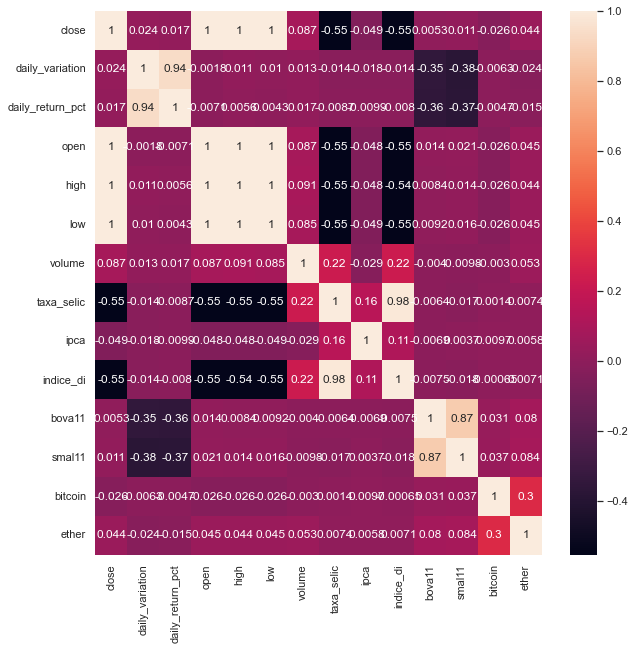

In [95]:
sns.heatmap(dolar_full.corr(method='pearson'), annot=True);

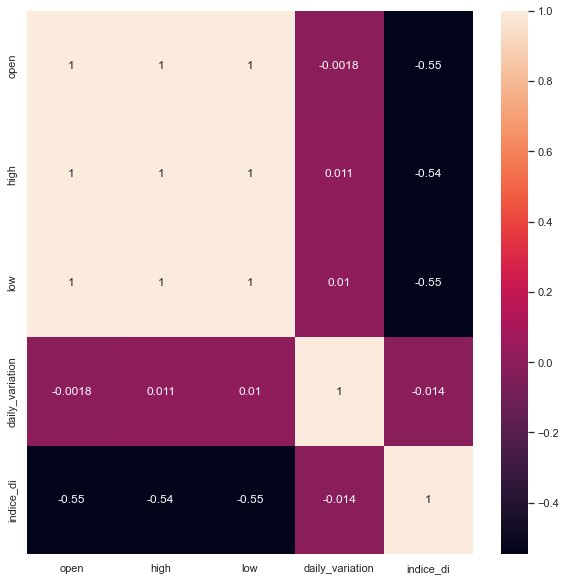

In [96]:
sns.heatmap(dolar_full[['open', 'high', 'low', 'daily_variation', 'indice_di']].corr(method='pearson'), annot=True);

### Bova11

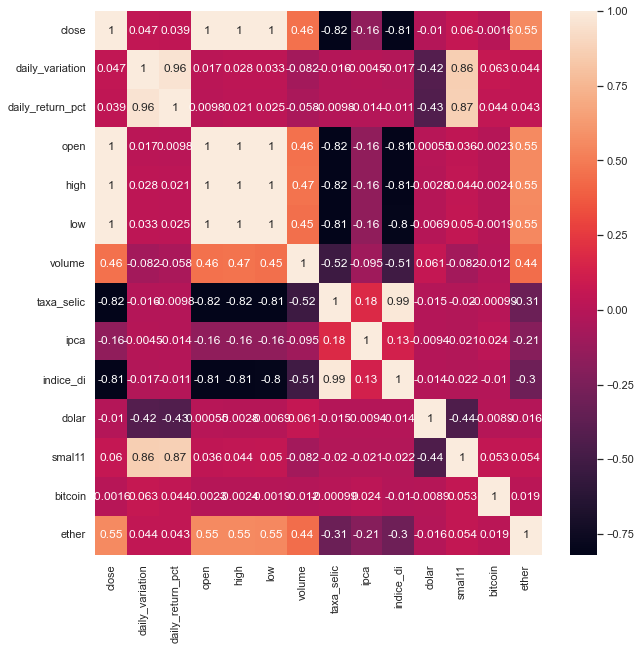

In [97]:
sns.heatmap(bova11_full.corr(method='pearson'), annot=True);

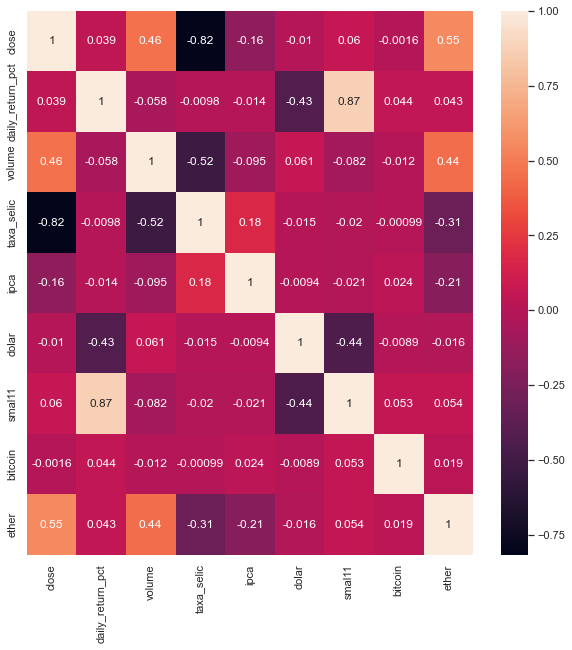

In [98]:
sns.heatmap(bova11_full.drop(['open', 'high', 'low', 'daily_variation', 'indice_di'], axis=1).corr(method='pearson'), annot=True);

### Smal11

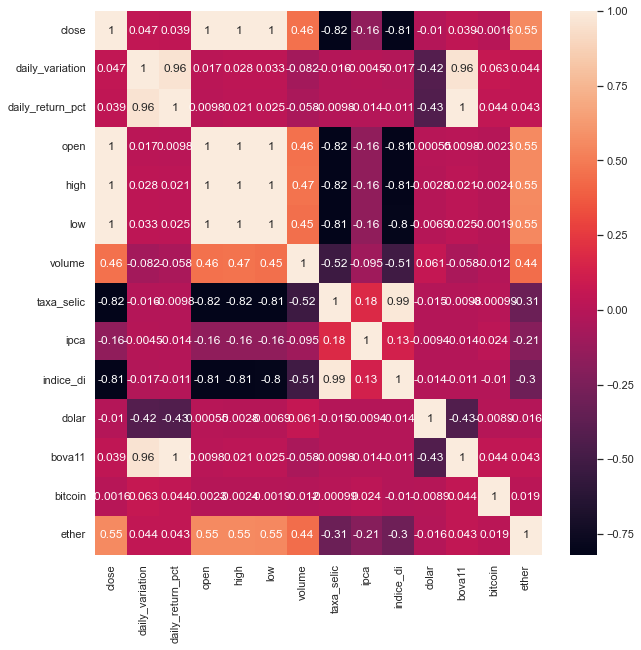

In [99]:
sns.heatmap(smal11_full.corr(method='pearson'), annot=True);

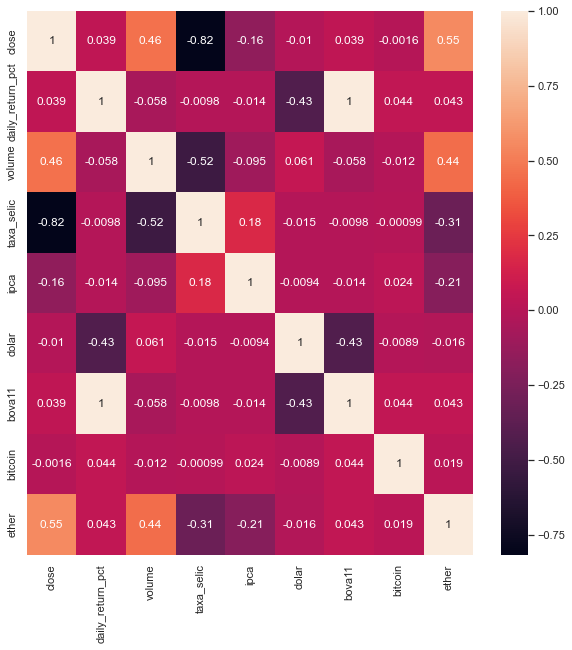

In [100]:
sns.heatmap(smal11_full.drop(['open', 'high', 'low', 'daily_variation', 'indice_di'], axis=1).corr(method='pearson'), annot=True);

### Bitcoin

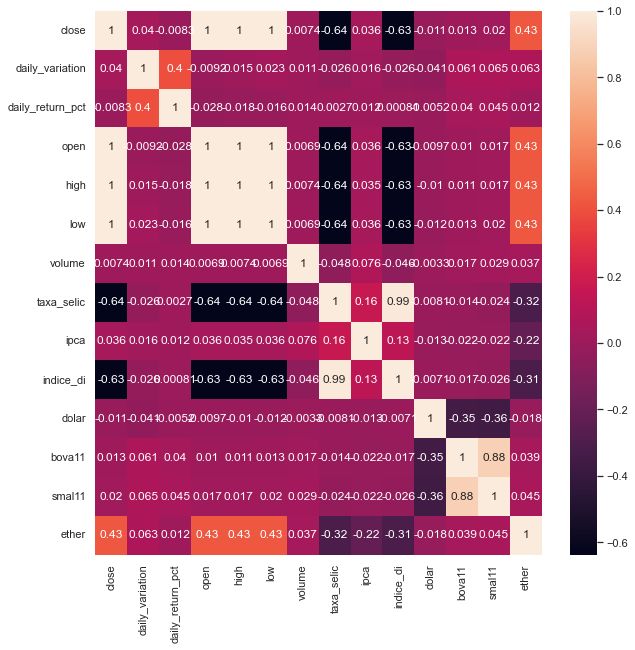

In [101]:
sns.heatmap(bitcoin_full.corr(method='pearson'), annot=True);

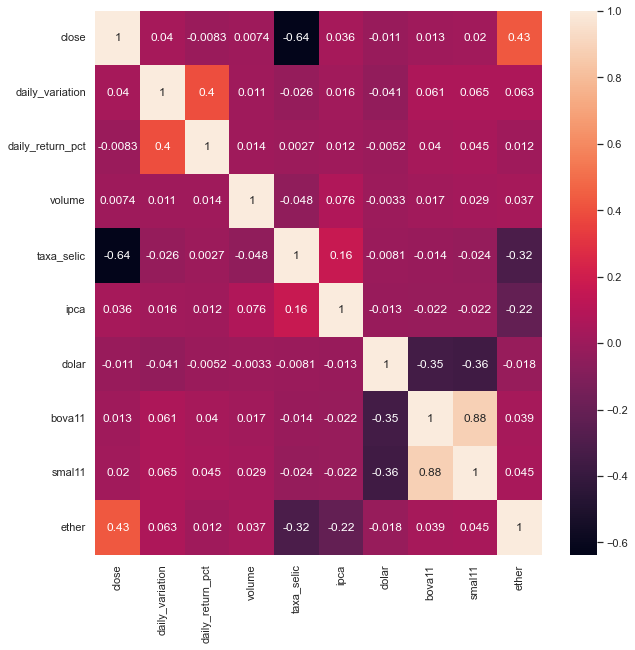

In [102]:
sns.heatmap(bitcoin_full.drop(['open', 'high', 'low', 'indice_di'], axis=1).corr(method='pearson'), annot=True);

### Ether

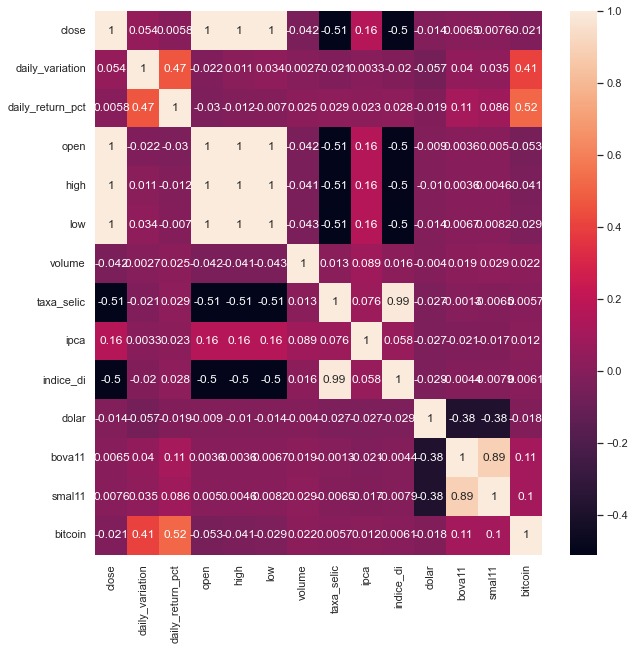

In [103]:
sns.heatmap(ether_full.corr(method='pearson'), annot=True);

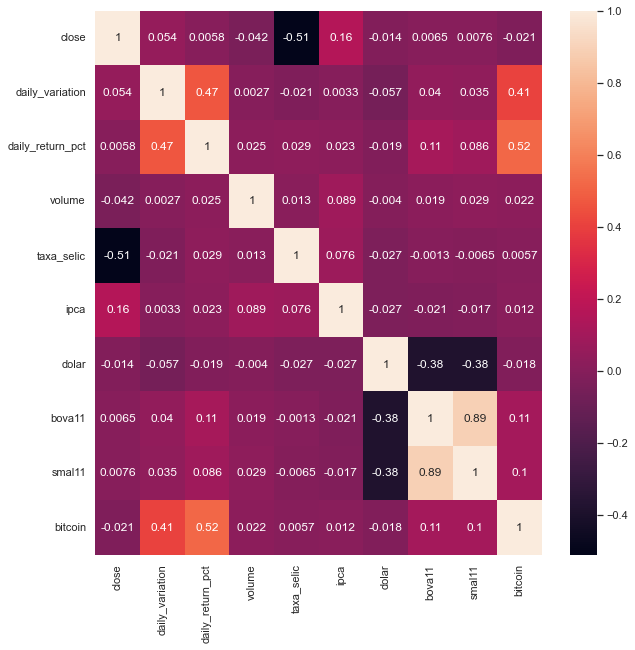

In [104]:
sns.heatmap(ether_full.drop(['open', 'high', 'low', 'indice_di'], axis=1).corr(method='pearson'), annot=True);

In [105]:
# Drop columns according to correlation matrix - avoid multicollinearity
dolar_full.drop(['open', 'high', 'low', 'daily_variation', 'indice_di'], axis=1, inplace=True)
bova11_full.drop(['open', 'high', 'low', 'daily_variation', 'indice_di'], axis=1, inplace=True)
smal11_full.drop(['open', 'high', 'low', 'daily_variation', 'indice_di'], axis=1, inplace=True)
bitcoin_full.drop(['open', 'high', 'low', 'indice_di'], axis=1, inplace=True)
ether_full.drop(['open', 'high', 'low', 'indice_di'], axis=1, inplace=True)

# 7.0 Machine Learning Modelling

In [106]:
## Define the limit date to test set: 1 Trading Stock Year 
# 252

test_period = dolar.index.max() - datetime.timedelta(days=730)
test_period

Timestamp('2019-07-20 00:00:00')

In [107]:
# def ml_error(model_name, y, yhat):
#     mae = mean_absolute_error(y,yhat)
#     rmse = np.sqrt(mean_squared_error(y,yhat)) 
    
#     return pd.DataFrame({'Model Name': model_name,
#                          'MAE':mae,
#                         'RMSE':rmse}, index=[0])

In [108]:
# def cross_validation(x_training, kfold, model_name, model, verbose=True):
#     mae_list = []
#     rmse_list = []
#     for k in reversed(range(1,kfold+1)):
#         if verbose:
#             print('Kfold Number: {}'.format(k))
#         # start and end date for validation
#         validation_start_date = x_training.index.max() - datetime.timedelta(days=k*90)
#         validation_end_date = x_training.index.max() - datetime.timedelta(days=(k-1)*90)

#         # filtering dataset
#         training = x_training[x_training.index < validation_start_date]
#         validation = x_training[(x_training.index >= validation_start_date) & (x_training.index <= validation_end_date)]

#         # training and validation dataset
#         xtraining = training.drop(['daily_return_pct','symbol'], axis=1)
#         ytraining = training['daily_return_pct']

#         xvalidation = validation.drop(['daily_return_pct','symbol'],axis=1)
#         yvalidation = validation['daily_return_pct']

#         # model
#         m = model.fit(xtraining, ytraining)

#         # prediction
#         yhat = m.predict(xvalidation)

#         # performance
#         m_result = ml_error(model_name, yvalidation, yhat) #np.expm1(yvalidation), np.expm1(yhat))

#         # store perfomance of each kfold iteration
#         mae_list.append(m_result['MAE'])
#         rmse_list.append(m_result['RMSE'])

#     return pd.DataFrame({'Model':model_name,
#         'MAE cv': np.round(np.mean(mae_list),5).astype(str) + '+/-' + np.round(np.std(mae_list),4).astype(str),
#         'RMSE cv': np.round(np.mean(rmse_list),5).astype(str) + '+/-' + np.round(np.std(rmse_list),4).astype(str)}, index=[0])


## 7.1 Dolar

In [204]:
# Train Dataset
X_train_dolar = dolar_full[dolar.index < test_period]
y_train_dolar = X_train_dolar['daily_return_pct']

# Test Dataset
X_test_dolar = dolar_full[dolar_full.index >= test_period]
y_test_dolar = X_test_dolar['daily_return_pct']


### Linear Regression

In [110]:
# Model Definition
lr_dolar = LinearRegression()

dolar_lr = cross_validation(X_train_dolar, 10, 'Linear Regression', lr_dolar, verbose=True)
dolar_lr

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Linear Regression  0.00462+/-0.0008  0.00659+/-0.0013

In [111]:
# Train Dataset
X_train_dolar = dolar_full[dolar_full.index < test_period].drop('symbol', axis=1)
y_train_dolar = X_train_dolar['daily_return_pct']

# Test Dataset
X_test_dolar = dolar_full[dolar_full.index >= test_period].drop('symbol', axis=1)
y_test_dolar = X_test_dolar['daily_return_pct']

# Model Training
lr_dolar.fit(X_train_dolar, y_train_dolar)

# Model prediction
yhat_lr_dolar = lr_dolar.predict(X_test_dolar)

# Model Performance
lr_result_dolar = ml_error('Linear Regression', y_test_dolar, yhat_lr_dolar)
lr_result_dolar

Model Name     MAE    RMSE
0  Linear Regression 0.00000 0.00000

The R1 Score is:  1.0


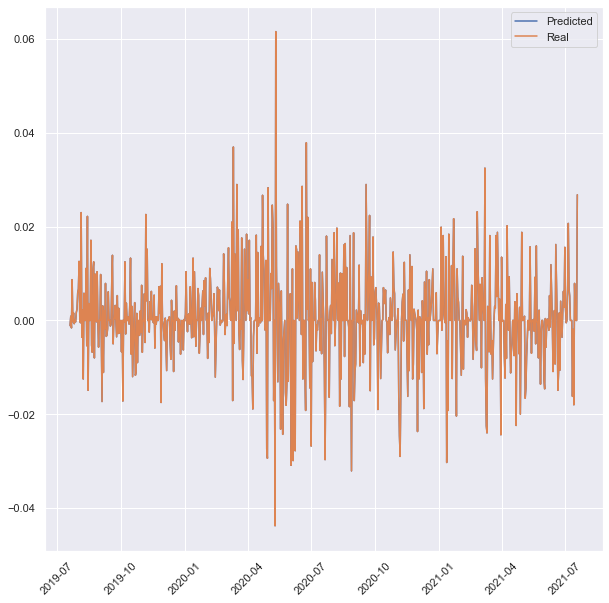

In [112]:
yhat_lr_dolar = pd.DataFrame(yhat_lr_dolar)
yhat_lr_dolar.set_index(y_test_dolar.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_lr_dolar, y_test_dolar))

plt.plot(yhat_lr_dolar, label='Predicted')
plt.plot(y_test_dolar, label='Real')
plt.xticks(rotation='45')
plt.legend();

<AxesSubplot:xlabel='date'>

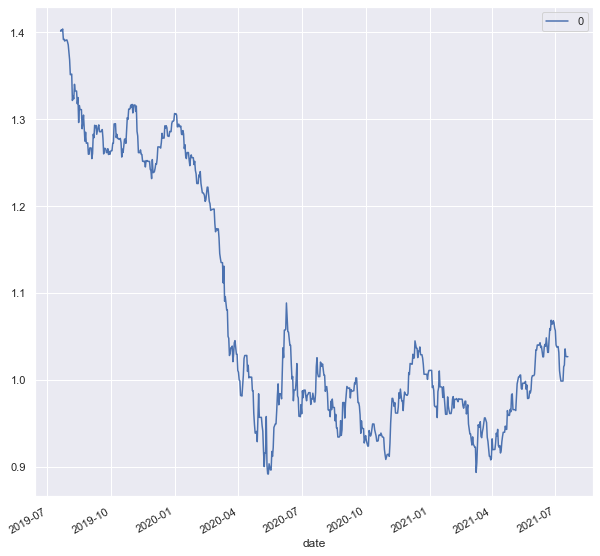

In [183]:
(1+yhat_lr_dolar).cumprod().plot()

<AxesSubplot:xlabel='date'>

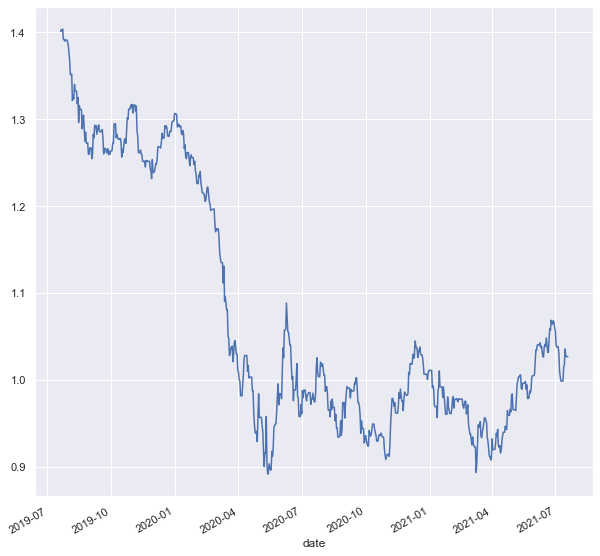

In [184]:
(1+y_test_dolar).cumprod().plot()

### XGBoost Regressor

In [113]:
# Train Dataset
X_train_dolar = dolar_full[dolar_full.index < test_period]
y_train_dolar = X_train_dolar['daily_return_pct']

# Test Dataset
X_test_dolar = dolar_full[dolar_full.index >= test_period]
y_test_dolar = X_test_dolar['daily_return_pct']


In [114]:
# Model Definition
xgb_dolar = xgb.XGBRegressor(random_state=42)

dolar_cv_xgb = cross_validation(X_train_dolar, 10, 'XGBoost Regressor', xgb_dolar, verbose=True)
dolar_cv_xgb

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  XGBoost Regressor  0.00567+/-0.0011  0.00804+/-0.0018

In [115]:
# Train Dataset
X_train_dolar = dolar_full[dolar_full.index < test_period].drop('symbol', axis=1)
y_train_dolar = X_train_dolar['daily_return_pct']

# Test Dataset
X_test_dolar = dolar_full[dolar_full.index >= test_period].drop('symbol', axis=1)
y_test_dolar = X_test_dolar['daily_return_pct']

# Model Training
xgb_dolar.fit(X_train_dolar, y_train_dolar)

# Model prediction
yhat_xgb_dolar = xgb_dolar.predict(X_test_dolar)

# Model Performance
xgb_result_dolar = ml_error('XGB Regressor', y_test_dolar, yhat_xgb_dolar)
xgb_result_dolar

Model Name     MAE    RMSE
0  XGB Regressor 0.00020 0.00054

The R1 Score is:  0.9972562978956481


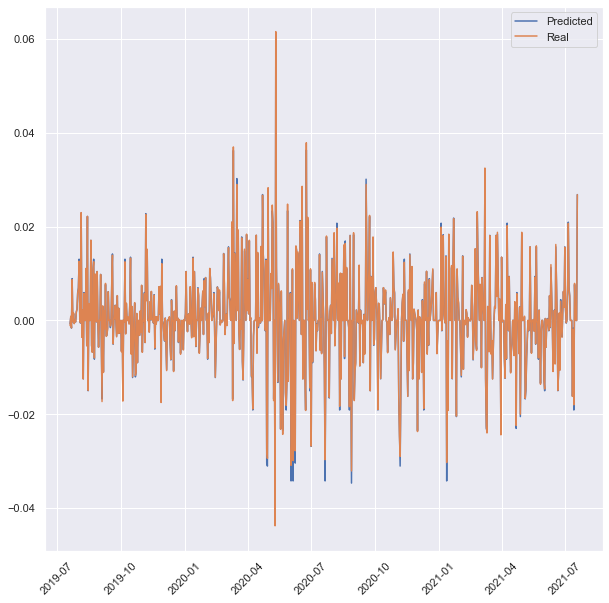

In [116]:
yhat_xgb_dolar = pd.DataFrame(yhat_xgb_dolar)
yhat_xgb_dolar.set_index(y_test_dolar.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_xgb_dolar, y_test_dolar))

plt.plot(yhat_xgb_dolar, label='Predicted')
plt.plot(y_test_dolar, label='Real')
plt.xticks(rotation='45')
plt.legend();

### Random Forest Regressor

In [117]:
# Train Dataset
X_train_dolar = dolar_full[dolar_full.index < test_period]
y_train_dolar = X_train_dolar['daily_return_pct']

# Test Dataset
X_test_dolar = dolar_full[dolar_full.index >= test_period]
y_test_dolar = X_test_dolar['daily_return_pct']

In [118]:
# Model Definition
rf_dolar = RandomForestRegressor(random_state=42)

dolar_cv_rf = cross_validation(X_train_dolar, 10, 'Random Forest Regressor', rf_dolar, verbose=True)
dolar_cv_rf

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Random Forest Regressor  0.00471+/-0.0008  0.00691+/-0.0014

In [119]:
# Train Dataset
X_train_dolar = dolar_full[dolar_full.index < test_period].drop('symbol', axis=1)
y_train_dolar = X_train_dolar['daily_return_pct']

# Test Dataset
X_test_dolar = dolar_full[dolar_full.index >= test_period].drop('symbol', axis=1)
y_test_dolar = X_test_dolar['daily_return_pct']

# Model Training
rf_dolar.fit(X_train_dolar, y_train_dolar)

# Model prediction
yhat_rf_dolar = rf_dolar.predict(X_test_dolar)

# Model Performance
rf_result_dolar = ml_error('Random Forest Regressor', y_test_dolar, yhat_rf_dolar)
rf_result_dolar

Model Name     MAE    RMSE
0  Random Forest Regressor 0.00009 0.00059

The R1 Score is:  0.9967243255626348


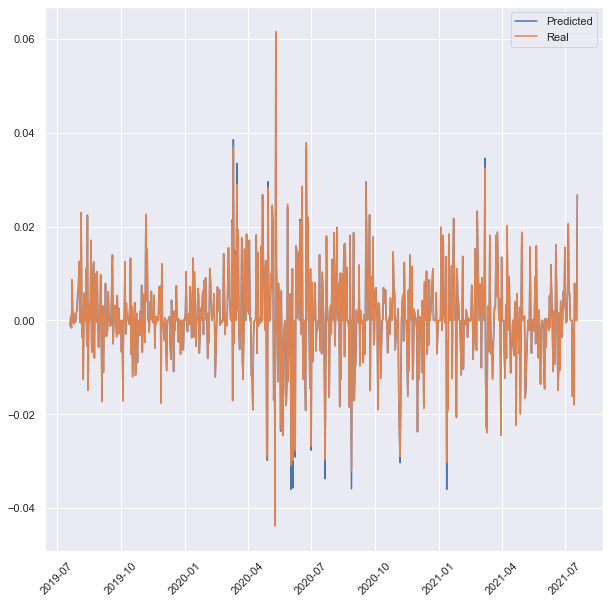

In [120]:
yhat_rf_dolar = pd.DataFrame(yhat_rf_dolar)
yhat_rf_dolar.set_index(y_test_dolar.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_rf_dolar, y_test_dolar))

plt.plot(yhat_rf_dolar, label='Predicted')
plt.plot(y_test_dolar, label='Real')
plt.xticks(rotation='45')
plt.legend();

## 7.2 BOVA11

In [121]:
# Train Dataset
X_train_bova11 = bova11_full[bova11_full.index < test_period]
y_train_bova11 = bova11_full[bova11_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bova11 = bova11_full[bova11_full.index >= test_period]
y_test_bova11 = bova11_full[bova11_full.index >= test_period]['daily_return_pct']

### Linear Regression

In [122]:
# Model Definition
lr_bova11 = LinearRegression()

lr_cv_bova11 = cross_validation(X_train_bova11, 10, 'Linear Regression', lr_bova11, verbose=True)
lr_cv_bova11

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv          RMSE cv
0  Linear Regression  0.00509+/-0.0007  0.0067+/-0.0012

In [123]:
# Train Dataset
X_train_bova11 = bova11_full[bova11_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_bova11 = bova11_full[bova11_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bova11 = bova11_full[bova11_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_bova11 = bova11_full[bova11_full.index >= test_period]['daily_return_pct']

# Model training
lr_bova11.fit(X_train_bova11, y_train_bova11)

# Model Prediction
yhat_lr_bova11 = lr_bova11.predict(X_test_bova11)

# Model Performance
lr_result_bova11 = ml_error('Linear Regression', y_test_bova11, yhat_lr_bova11)
lr_result_bova11

Model Name     MAE    RMSE
0  Linear Regression 0.00704 0.00980

The R1 Score is:  0.8246077918945705


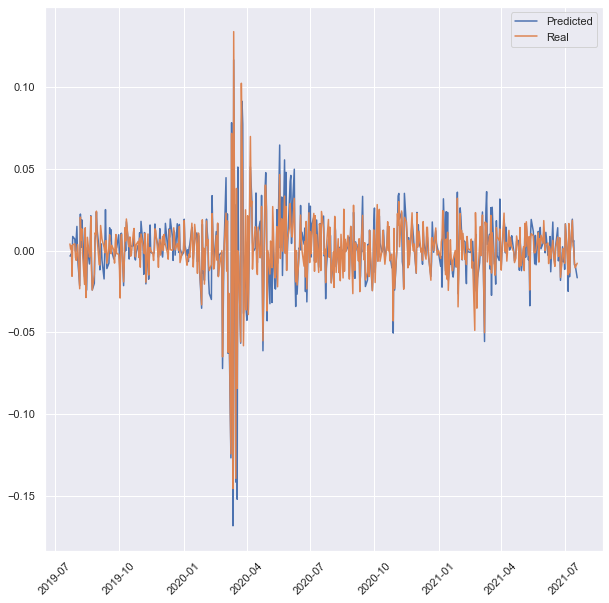

In [124]:
yhat_lr_bova11 = pd.DataFrame(yhat_lr_bova11)
yhat_lr_bova11.set_index(y_test_bova11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_lr_bova11, y_test_bova11))

plt.plot(yhat_lr_bova11, label='Predicted')
plt.plot(y_test_bova11, label='Real')
plt.xticks(rotation='45')
plt.legend();

### XGB Regressor

In [125]:
# Train Dataset
X_train_bova11 = bova11_full[bova11_full.index < test_period]
y_train_bova11 = bova11_full[bova11_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bova11 = bova11_full[bova11_full.index >= test_period]
y_test_bova11 = bova11_full[bova11_full.index >= test_period]['daily_return_pct']

In [126]:
# Model Definition
xgb_bova11 = xgb.XGBRegressor(random_state=42)

xgb_cv_bova11 = cross_validation(X_train_bova11, 10, 'XGBoost Regressor', xgb_bova11, verbose=True)
xgb_cv_bova11

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  XGBoost Regressor  0.00598+/-0.0007  0.00782+/-0.0011

In [127]:
# Train Dataset
X_train_bova11 = bova11_full[bova11_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_bova11 = bova11_full[bova11_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bova11 = bova11_full[bova11_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_bova11 = bova11_full[bova11_full.index >= test_period]['daily_return_pct']

# Model training
xgb_bova11.fit(X_train_bova11, y_train_bova11)

# Model Prediction
yhat_xgb_bova11 = xgb_bova11.predict(X_test_bova11)

# Model Performance
xgb_result_bova11 = ml_error('XGBoost Regressor', y_test_bova11, yhat_xgb_bova11)
xgb_result_bova11

Model Name     MAE    RMSE
0  XGBoost Regressor 0.00821 0.01189

The R1 Score is:  0.642031203878143


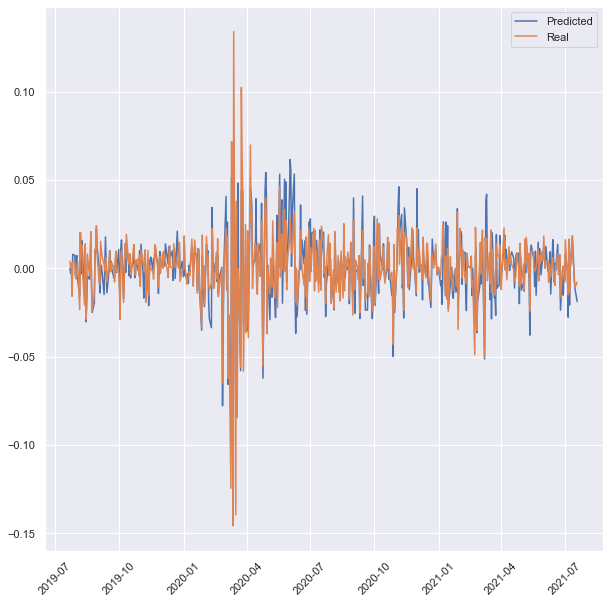

In [128]:
yhat_xgb_bova11 = pd.DataFrame(yhat_xgb_bova11)
yhat_xgb_bova11.set_index(y_test_bova11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_xgb_bova11, y_test_bova11))

plt.plot(yhat_xgb_bova11, label='Predicted')
plt.plot(y_test_bova11, label='Real')
plt.xticks(rotation='45')
plt.legend();

### Random Forest Regressor

In [129]:
# Train Dataset
X_train_bova11 = bova11_full[bova11_full.index < test_period]
y_train_bova11 = bova11_full[bova11_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bova11 = bova11_full[bova11_full.index >= test_period]
y_test_bova11 = bova11_full[bova11_full.index >= test_period]['daily_return_pct']

In [130]:
# Model Definition
rf_bova11 = RandomForestRegressor(random_state=42)

bova11_cv_rf = cross_validation(X_train_bova11, 10, 'Random Forest Regressor', rf_bova11, verbose=True)
bova11_cv_rf

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model           MAE cv          RMSE cv
0  Random Forest Regressor  0.00522+/-0.001  0.0069+/-0.0014

In [131]:
# Train Dataset
X_train_bova11 = bova11_full[bova11_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_bova11 = bova11_full[bova11_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bova11 = bova11_full[bova11_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_bova11 = bova11_full[bova11_full.index >= test_period]['daily_return_pct']

# Model training
rf_bova11.fit(X_train_bova11, y_train_bova11)

# Model Prediction
yhat_rf_bova11 = rf_bova11.predict(X_test_bova11)

# Model Performance
rf_result_bova11 = ml_error('Random Forest Regressor', y_test_bova11, yhat_rf_bova11)
rf_result_bova11

Model Name     MAE    RMSE
0  Random Forest Regressor 0.00777 0.01162

The R1 Score is:  0.6304599477183628


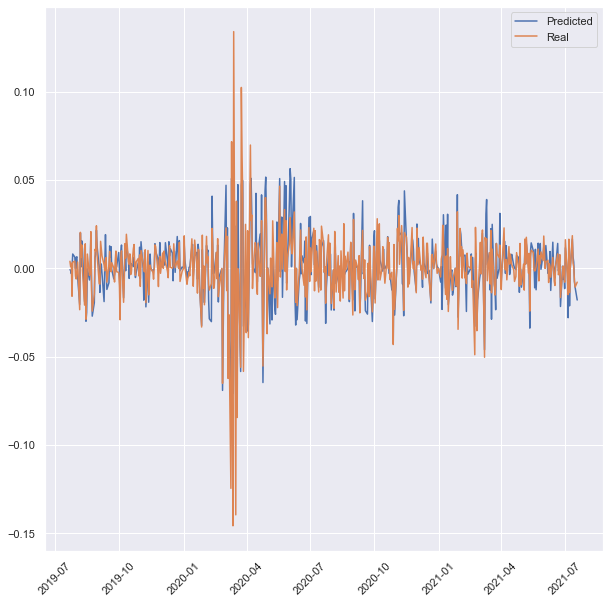

In [132]:
yhat_rf_bova11 = pd.DataFrame(yhat_rf_bova11)
yhat_rf_bova11.set_index(y_test_bova11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_rf_bova11, y_test_bova11))

plt.plot(yhat_rf_bova11, label='Predicted')
plt.plot(y_test_bova11, label='Real')
plt.xticks(rotation='45')
plt.legend();

## 7.3 SMAL11

In [133]:
# Train Dataset
X_train_smal11 = smal11_full[smal11_full.index < test_period]
y_train_smal11 = X_train_smal11['daily_return_pct']

# Test Dataset
X_test_smal11 = smal11_full[smal11_full.index >= test_period]
y_test_smal11 = X_test_smal11['daily_return_pct']

### Linear Regression

In [134]:
# Model Definition
lr_smal11 = LinearRegression()

smal11_lr = cross_validation(X_train_smal11, 10, 'Linear Regression', lr_smal11, verbose=True)
smal11_lr

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model     MAE cv    RMSE cv
0  Linear Regression  0.0+/-0.0  0.0+/-0.0

In [135]:
# Train Dataset
X_train_smal11 = smal11_full[smal11_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_smal11 = smal11_full[smal11_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_smal11 = smal11_full[smal11_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_smal11 = smal11_full[smal11_full.index >= test_period]['daily_return_pct']

# Model training
lr_smal11.fit(X_train_smal11, y_train_smal11)

# Model Prediction
yhat_lr_smal11 = lr_smal11.predict(X_test_smal11)

# Model Performance
lr_result_smal11 = ml_error('Linear Regression', y_test_smal11, yhat_lr_smal11)
lr_result_smal11

Model Name     MAE    RMSE
0  Linear Regression 0.00000 0.00000

The R1 Score is:  1.0


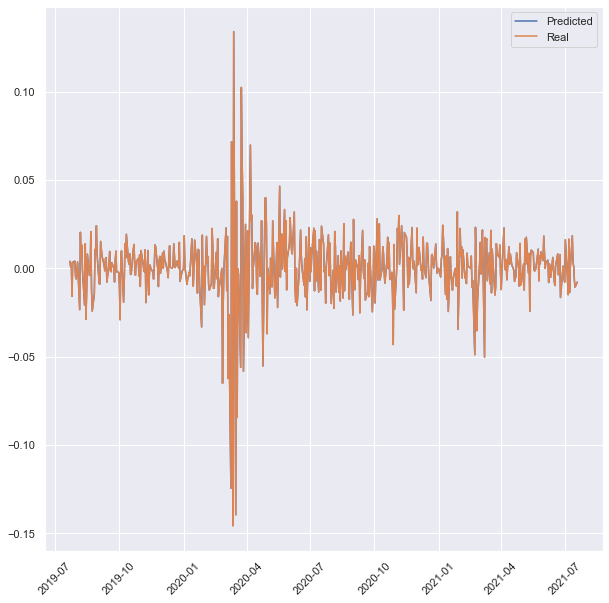

In [136]:
yhat_lr_smal11 = pd.DataFrame(yhat_lr_smal11)
yhat_lr_smal11.set_index(y_test_smal11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_lr_smal11, y_test_smal11))

plt.plot(yhat_lr_smal11, label='Predicted')
plt.plot(y_test_smal11, label='Real')
plt.xticks(rotation='45')
plt.legend();

### XGB Regressor

In [137]:
# Train Dataset
X_train_smal11 = smal11_full[smal11_full.index < test_period]
y_train_smal11 = X_train_smal11['daily_return_pct']

# Test Dataset
X_test_smal11 = smal11_full[smal11_full.index >= test_period]
y_test_smal11 = X_test_smal11['daily_return_pct']

In [138]:
# Model Definition
xgb_smal11 = xgb.XGBRegressor(random_state=42)

smal11_xgb = cross_validation(X_train_smal11, 10, 'XGB Regressor', xgb_smal11, verbose=True)
smal11_xgb

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model         MAE cv           RMSE cv
0  XGB Regressor  0.00024+/-0.0  0.00038+/-0.0001

In [139]:
# Train Dataset
X_train_smal11 = smal11_full[smal11_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_smal11 = smal11_full[smal11_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_smal11 = smal11_full[smal11_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_smal11 = smal11_full[smal11_full.index >= test_period]['daily_return_pct']

# Model training
xgb_smal11.fit(X_train_smal11, y_train_smal11)

# Model Prediction
yhat_xgb_smal11 = xgb_smal11.predict(X_test_smal11)

# Model Performance
xgb_result_smal11 = ml_error('XGBoost Regressor', y_test_smal11, yhat_xgb_smal11)
xgb_result_smal11

Model Name     MAE    RMSE
0  XGBoost Regressor 0.00091 0.00534

The R1 Score is:  0.9123476224961642


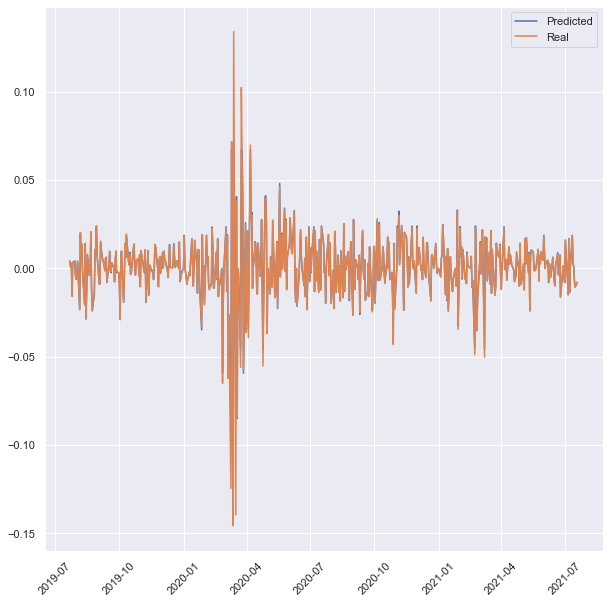

In [140]:
yhat_xgb_smal11 = pd.DataFrame(yhat_xgb_smal11)
yhat_xgb_smal11.set_index(y_test_smal11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_xgb_smal11, y_test_smal11))

plt.plot(yhat_xgb_smal11, label='Predicted')
plt.plot(y_test_smal11, label='Real')
plt.xticks(rotation='45')
plt.legend();

### Random Forest Regressor

In [141]:
# Train Dataset
X_train_smal11 = smal11_full[smal11_full.index < test_period]
y_train_smal11 = X_train_smal11['daily_return_pct']

# Test Dataset
X_test_smal11 = smal11_full[smal11_full.index >= test_period]
y_test_smal11 = X_test_smal11['daily_return_pct']

In [142]:
# Model Definition
rf_smal11 = RandomForestRegressor(random_state=42)

smal11_rf = cross_validation(X_train_smal11, 10, 'XGB Regressor', rf_smal11, verbose=True)
smal11_rf

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model          MAE cv           RMSE cv
0  XGB Regressor  7e-05+/-0.0001  0.00037+/-0.0008

In [143]:
# Train Dataset
X_train_smal11 = smal11_full[smal11_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_smal11 = smal11_full[smal11_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_smal11 = smal11_full[smal11_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_smal11 = smal11_full[smal11_full.index >= test_period]['daily_return_pct']

# Model training
rf_smal11.fit(X_train_smal11, y_train_smal11)

# Model Prediction
yhat_rf_smal11 = rf_smal11.predict(X_test_smal11)

# Model Performance
rf_result_smal11 = ml_error('Random Forest Regressor', y_test_smal11, yhat_rf_smal11)
rf_result_smal11

Model Name     MAE    RMSE
0  Random Forest Regressor 0.00076 0.00634

The R1 Score is:  0.8692016386055748


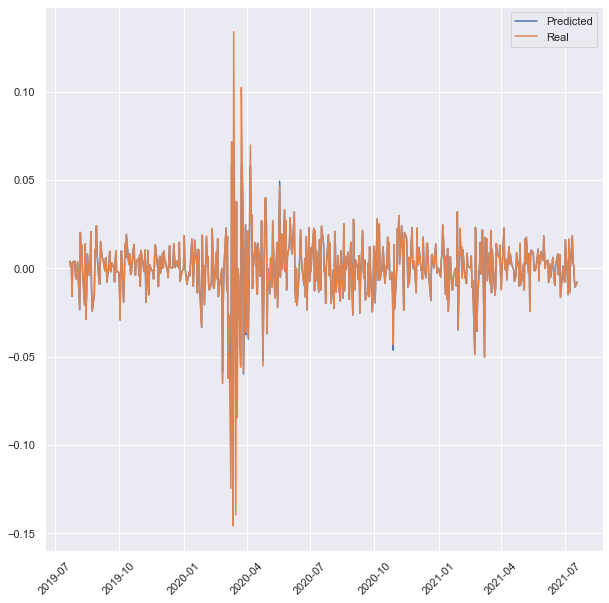

In [144]:
yhat_rf_smal11 = pd.DataFrame(yhat_rf_smal11)
yhat_rf_smal11.set_index(y_test_smal11.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_rf_smal11, y_test_smal11))

plt.plot(yhat_rf_smal11, label='Predicted')
plt.plot(y_test_smal11, label='Real')
plt.xticks(rotation='45')
plt.legend();

## 7.4 Bitcoin

In [145]:
# Train Dataset
X_train_bitcoin = bitcoin_full[bitcoin_full.index < test_period]
y_train_bitcoin1 = bitcoin_full[bitcoin_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period]
y_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period]['daily_return_pct']

### Linear Regression

In [146]:
# Model Definition
lr_bit = LinearRegression()

lr_cv_bit = cross_validation(X_train_bitcoin, 10, 'Linear Regression', lr_bit, verbose=True )
lr_cv_bit

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model           MAE cv           RMSE cv
0  Linear Regression  0.05528+/-0.081  0.07904+/-0.1189

In [147]:
# Train Dataset
X_train_bitcoin = bitcoin_full[bitcoin_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_bitcoin = bitcoin_full[bitcoin_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period]['daily_return_pct']

# Model training
lr_bit.fit(X_train_bitcoin, y_train_bitcoin)

# Model Prediction
yhat_lr_bitcoin = lr_bit.predict(X_test_bitcoin)

# Model Performance
lr_result_bitcoin = ml_error('Linear Regression', y_test_bitcoin, yhat_lr_bitcoin)
lr_result_bitcoin

Model Name     MAE    RMSE
0  Linear Regression 0.11948 0.85196

The R1 Score is:  0.005678854017362234


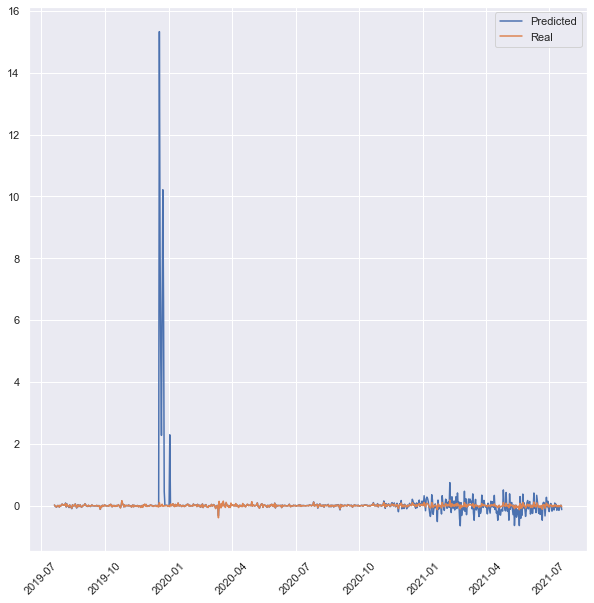

In [148]:
yhat_lr_bitcoin = pd.DataFrame(yhat_lr_bitcoin)
yhat_lr_bitcoin.set_index(y_test_bitcoin.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_lr_bitcoin, y_test_bitcoin))

plt.plot(yhat_lr_bitcoin, label='Predicted')
plt.plot(y_test_bitcoin, label='Real')
plt.xticks(rotation='45')
plt.legend();

### XGB Regressor

In [149]:
# Train Dataset
X_train_bitcoin = bitcoin_full[bitcoin_full.index < test_period]
y_train_bitcoin = bitcoin_full[bitcoin_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period]
y_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period]['daily_return_pct']

In [150]:
# Model Definition
xgb_bitcoin = xgb.XGBRegressor(random_state=42)

bitcoin_xgb = cross_validation(X_train_bitcoin, 10, 'XGB Regressor', xgb_bitcoin, verbose=True)
bitcoin_xgb

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv        RMSE cv
0  XGB Regressor  0.01875+/-0.0179  0.0314+/-0.03

In [151]:
# Train Dataset
X_train_bitcoin = bitcoin_full[bitcoin_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_bitcoin = bitcoin_full[bitcoin_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period]['daily_return_pct']

# Model training
xgb_bitcoin.fit(X_train_bitcoin, y_train_bitcoin)

# Model Prediction
yhat_xgb_bitcoin = xgb_bitcoin.predict(X_test_bitcoin)

# Model Performance
xgb_result_bitcoin = ml_error('XGBoost Regressor', y_test_bitcoin, yhat_xgb_bitcoin)
xgb_result_bitcoin

Model Name     MAE    RMSE
0  XGBoost Regressor 0.01628 0.03511

The R1 Score is:  0.6811804040573652


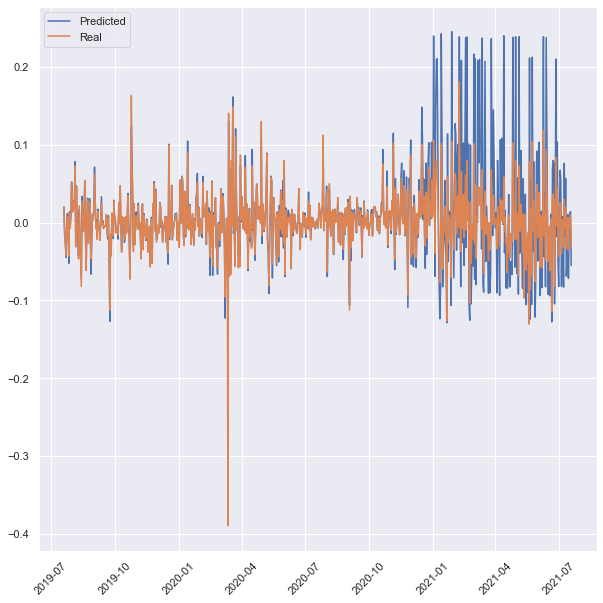

In [152]:
yhat_xgb_bitcoin = pd.DataFrame(yhat_xgb_bitcoin)
yhat_xgb_bitcoin.set_index(y_test_bitcoin.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_xgb_bitcoin, y_test_bitcoin))

plt.plot(yhat_xgb_bitcoin, label='Predicted')
plt.plot(y_test_bitcoin, label='Real')
plt.xticks(rotation='45')
plt.legend();

### Random Foret Regressor

In [153]:
# Train Dataset
X_train_bitcoin = bitcoin_full[bitcoin_full.index < test_period]
y_train_bitcoin1 = bitcoin_full[bitcoin_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period]
y_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period]['daily_return_pct']

In [154]:
# Model Definition
rf_bitcoin = RandomForestRegressor(random_state=42)

bitcoin_rf = cross_validation(X_train_bitcoin, 10, 'Random Forest Regressor', rf_bitcoin, verbose=True)
bitcoin_rf

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Random Forest Regressor  0.02069+/-0.0201  0.03013+/-0.0251

In [155]:
# Train Dataset
X_train_bitcoin = bitcoin_full[bitcoin_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_bitcoin = bitcoin_full[bitcoin_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_bitcoin = bitcoin_full[bitcoin_full.index >= test_period]['daily_return_pct']

# Model training
rf_bitcoin.fit(X_train_bitcoin, y_train_bitcoin)

# Model Prediction
yhat_rf_bitcoin = rf_bitcoin.predict(X_test_bitcoin)

# Model Performance
rf_result_bitcoin = ml_error('Random Forest Regressor', y_test_bitcoin, yhat_rf_bitcoin)
rf_result_bitcoin

Model Name     MAE    RMSE
0  Random Forest Regressor 0.01738 0.03311

The R1 Score is:  0.6981455683960038


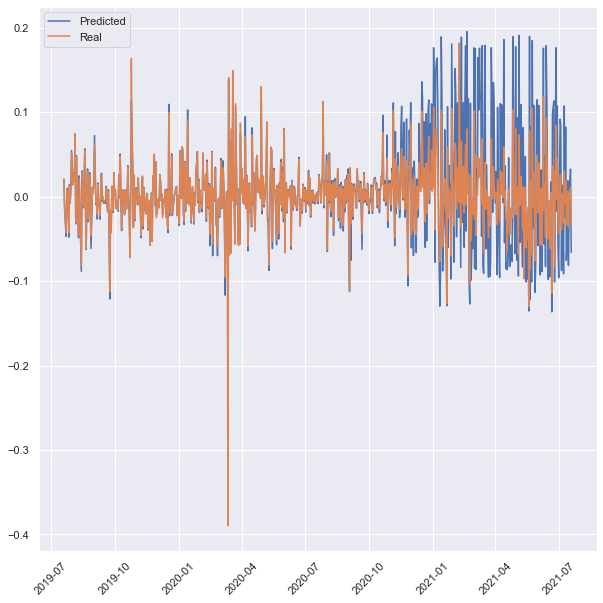

In [156]:
yhat_rf_bitcoin = pd.DataFrame(yhat_rf_bitcoin)
yhat_rf_bitcoin.set_index(y_test_bitcoin.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_rf_bitcoin, y_test_bitcoin))


plt.plot(yhat_rf_bitcoin, label='Predicted')
plt.plot(y_test_bitcoin, label='Real')
plt.xticks(rotation='45')
plt.legend();

## 7.5 Ether

In [157]:
# Train Dataset
X_train_ether = ether_full[ether_full.index < test_period]
y_train_ether = ether_full[ether_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_ether = ether_full[ether_full.index >= test_period]
y_test_ether = ether_full[ether_full.index >= test_period]['daily_return_pct']

### Linear Regression

In [158]:
lr_ether = LinearRegression()

lr_cv_ether = cross_validation(X_train_ether, 10, 'Linear Regression', lr_ether, verbose=True)
lr_cv_ether

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Linear Regression  0.08433+/-0.1273  0.12619+/-0.1762

In [159]:
# Train Dataset
X_train_ether = ether[ether.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_ether = ether[ether.index < test_period]['daily_return_pct']

# Test Dataset
X_test_ether = ether[ether.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_ether = ether[ether.index >= test_period]['daily_return_pct']

# Model training
lr_ether.fit(X_train_ether, y_train_ether)

# Model Prediction
yhat_lr_ether = lr_ether.predict(X_test_ether)

# Model Performance
lr_result_ether = ml_error('Linear Regression', y_test_ether, yhat_lr_ether)
lr_result_ether

Model Name     MAE    RMSE
0  Linear Regression 0.05226 0.11505

The R1 Score is:  0.3487374655135904


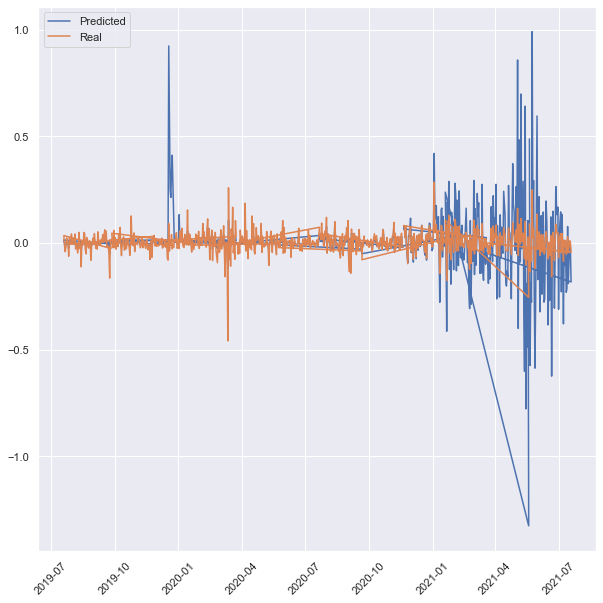

In [160]:
yhat_lr_ether = pd.DataFrame(yhat_lr_ether)
yhat_lr_ether.set_index(y_test_ether.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_lr_ether, y_test_ether))

plt.plot(yhat_lr_ether, label='Predicted')
plt.plot(y_test_ether, label='Real')
plt.xticks(rotation='45')
plt.legend();

### XGB Regressor

In [161]:
# Train Dataset
X_train_ether = ether_full[ether_full.index < test_period]
y_train_ether = ether_full[ether_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_ether = ether_full[ether_full.index >= test_period]
y_test_ether = ether_full[ether_full.index >= test_period]['daily_return_pct']

In [162]:
xgb_ether = xgb.XGBRegressor(random_state=42)

xgb_cv_ether = cross_validation(X_train_ether, 10, 'XGBoost Regressor', xgb_ether, verbose=True)
xgb_cv_ether

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  XGBoost Regressor  0.02108+/-0.0169  0.03144+/-0.0238

In [163]:
# Train Dataset
X_train_ether = ether_full[ether_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_ether = ether_full[ether_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_ether = ether_full[ether_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_ether = ether_full[ether_full.index >= test_period]['daily_return_pct']

# Model training
xgb_ether.fit(X_train_ether, y_train_ether)

# Model Prediction
yhat_xgb_ether = xgb_ether.predict(X_test_ether)

# Model Performance
xgb_result_ether = ml_error('XGBoost Regressor', y_test_ether, yhat_xgb_ether)
xgb_result_ether

Model Name     MAE    RMSE
0  XGBoost Regressor 0.01268 0.02373

The R1 Score is:  0.8151518168469151


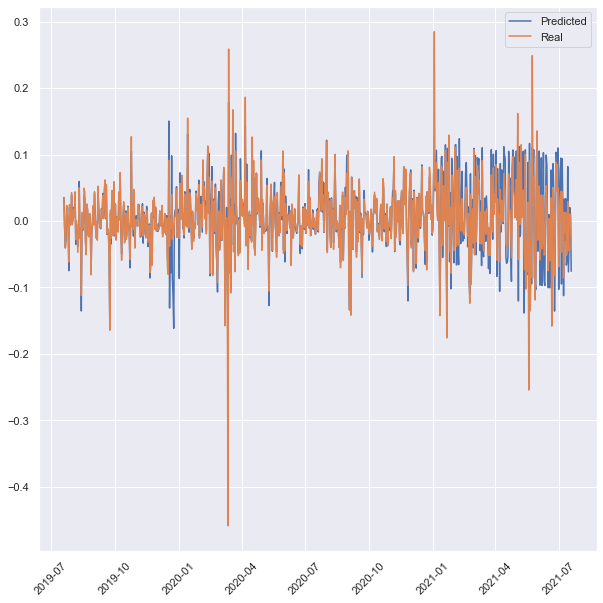

In [164]:
yhat_xgb_ether = pd.DataFrame(yhat_xgb_ether)
yhat_xgb_ether.set_index(y_test_ether.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_xgb_ether, y_test_ether))

plt.plot(yhat_xgb_ether, label='Predicted')
plt.plot(y_test_ether, label='Real')
plt.xticks(rotation='45')
plt.legend();

### Random Forest Regressor

In [165]:
# Train Dataset
X_train_ether = ether_full[ether_full.index < test_period]
y_train_ether = ether_full[ether_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_ether = ether_full[ether_full.index >= test_period]
y_test_ether = ether_full[ether_full.index >= test_period]['daily_return_pct']

In [166]:
rf_ether = RandomForestRegressor(random_state=42)

rf_cv_ether = cross_validation(X_train_ether, 10, 'Random Forest Regressor', rf_ether, verbose=True)
rf_cv_ether

Kfold Number: 10
Kfold Number: 9
Kfold Number: 8
Kfold Number: 7
Kfold Number: 6
Kfold Number: 5
Kfold Number: 4
Kfold Number: 3
Kfold Number: 2
Kfold Number: 1


Model            MAE cv           RMSE cv
0  Random Forest Regressor  0.02346+/-0.0172  0.03491+/-0.0214

In [167]:
# Train Dataset
X_train_ether = ether_full[ether_full.index < test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_train_ether = ether_full[ether_full.index < test_period]['daily_return_pct']

# Test Dataset
X_test_ether = ether_full[ether_full.index >= test_period].drop(['daily_return_pct', 'symbol'], axis=1)
y_test_ether = ether_full[ether_full.index >= test_period]['daily_return_pct']

# Model training
rf_ether.fit(X_train_ether, y_train_ether)

# Model Prediction
yhat_rf_ether = rf_ether.predict(X_test_ether)

# Model Performance
rf_result_ether = ml_error('Random Forest Regressor', y_test_ether, yhat_rf_ether)
rf_result_ether

Model Name     MAE    RMSE
0  Random Forest Regressor 0.01421 0.02793

The R1 Score is:  0.767539049694204


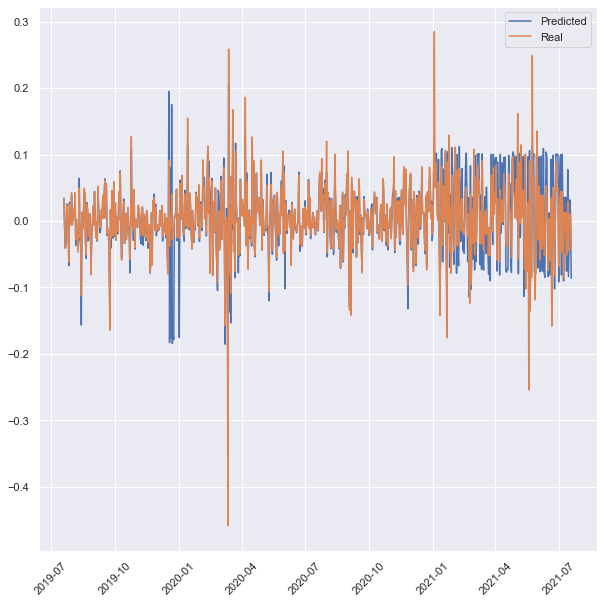

In [168]:
yhat_rf_ether = pd.DataFrame(yhat_rf_ether)
yhat_rf_ether.set_index(y_test_ether.index, inplace=True)
print('The R1 Score is: ',r2_score(yhat_rf_ether, y_test_ether))

plt.plot(yhat_rf_ether, label='Predicted')
plt.plot(y_test_ether, label='Real')
plt.xticks(rotation='45')
plt.legend();

# 8.0 Hyperparameter Fine-Tunning

# 9.0 Business Report

## 9.1 Portfolio proposal

Com intuito de traduzir as performance de Machine Learning em resultados de negócio, utilizaremos novamente a **Simulação de Monte Cartlo**, com auxílido da visualização da **Fronteira Eficiente**, para traçar uma recomendação de carteira ideal de investimento. 

O procedimento é o seguinte: definiremos um número de portfólio a serem criados de modo que os pesos de alocação para cada ativo sejam gerados aleatoriamente. Em cima disso, a Simulação de Monte Carlo resulta numa planilha como todos os portfólios gerados e suas respectivas rentabilidades e riscos. Ordenaremos esses portfólios para sabermos os Top 5 melhores portfólio em termos de retorno.

In [169]:
def concat_final_return(yhat_dolar, yhat_bova11, yhat_smal11, yhat_bitcoin, yhat_ether):
    # Change all the predict values column names to daily_return_pct before the merge
    for df in [yhat_dolar, yhat_bova11, yhat_smal11, yhat_bitcoin, yhat_ether]:
        df.columns = ['daily_return_pct']
    
    full_return_pct = yhat_dolar.copy()
    full_return_pct.rename(columns= {'daily_return_pct':'dolar'}, inplace=True)
    full_return_pct = full_return_pct.merge(yhat_bova11['daily_return_pct'], left_index=True, right_index=True, how='left')
    full_return_pct.rename(columns= {'daily_return_pct':'bova11'}, inplace=True)
    full_return_pct = full_return_pct.merge(yhat_smal11['daily_return_pct'], left_index=True, right_index=True, how='left')
    full_return_pct.rename(columns= {'daily_return_pct':'smal11'}, inplace=True)
    full_return_pct = full_return_pct.merge(yhat_bitcoin['daily_return_pct'], left_index=True, right_index=True, how='left')
    full_return_pct.rename(columns= {'daily_return_pct':'bitcoin'}, inplace=True)
    full_return_pct = full_return_pct.merge(yhat_ether['daily_return_pct'], left_index=True, right_index=True, how='left')
    full_return_pct.rename(columns= {'daily_return_pct':'ether'}, inplace=True)
    
    # Replacing BOVA11 and SMAL11 NAs (weekend days) with 0 
    full_return_pct.fillna(0, inplace=True)
    return full_return_pct

In [209]:
print(y_test_dolar.shape)
print(y_test_bova11.shape)
print(y_test_smal11.shape)
print(y_test_bitcoin.shape)
print(y_test_ether.shape)

(691,)
(514,)
(514,)
(731,)
(731,)


In [198]:
print(yhat_xgb_dolar.shape)
print(yhat_xgb_bova11.shape)
print(yhat_xgb_smal11.shape)
print(yhat_rf_bitcoin.shape)
print(yhat_rf_ether.shape)

(691, 1)
(514, 1)
(514, 1)
(731, 1)
(731, 1)


In [195]:
print('negative:', yhat_xgb_dolar.loc[yhat_xgb_dolar.daily_return_pct < 0 ].shape[0],'positive:', yhat_xgb_dolar.loc[yhat_xgb_dolar.daily_return_pct > 0 ].shape[0])
print('negative:', yhat_xgb_bova11.loc[yhat_xgb_bova11.daily_return_pct < 0 ].shape[0],'positive:', yhat_xgb_bova11.loc[yhat_xgb_bova11.daily_return_pct > 0 ].shape[0])
print('negative:', yhat_xgb_smal11.loc[yhat_xgb_smal11.daily_return_pct < 0 ].shape[0],'positive:', yhat_xgb_smal11.loc[yhat_xgb_smal11.daily_return_pct > 0 ].shape[0])
print('negative:', yhat_rf_bitcoin.loc[yhat_rf_bitcoin.daily_return_pct < 0 ].shape[0],'positive:', yhat_rf_bitcoin.loc[yhat_rf_bitcoin.daily_return_pct > 0 ].shape[0])
print('negative:', yhat_rf_ether.loc[yhat_rf_ether.daily_return_pct < 0 ].shape[0],'positive:', yhat_rf_ether.loc[yhat_rf_ether.daily_return_pct > 0 ].shape[0])

negative: 256 positive: 435
negative: 241 positive: 273
negative: 248 positive: 266
negative: 356 positive: 375
negative: 342 positive: 389


In [190]:
final_return = concat_final_return(yhat_xgb_dolar, yhat_xgb_bova11, yhat_xgb_smal11, yhat_rf_bitcoin, yhat_rf_ether)
final_return.head()

dolar   bova11   smal11  bitcoin    ether
date                                                  
2021-07-19 0.02684 -0.01880 -0.00803 -0.06617 -0.08625
2021-07-18 0.00000  0.00000  0.00000  0.03260  0.01204
2021-07-17 0.00000  0.00000  0.00000  0.01487  0.03177
2021-07-16 0.00063 -0.01209 -0.01055 -0.01939 -0.02822
2021-07-15 0.00766 -0.00778 -0.00715 -0.08148 -0.08349

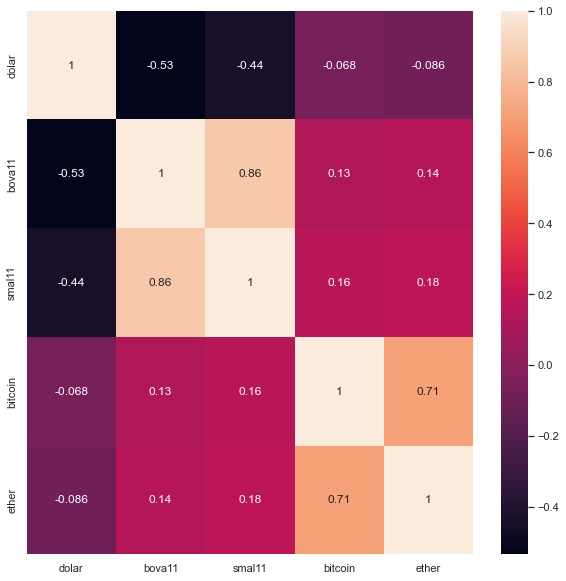

In [191]:
sns.heatmap(final_return.corr(), annot=True);

In [172]:
def monte_carlo(full_return_pct, num_portfolios):
    # Requeried inputs
    yearly_mean_return = full_return_pct.mean() *252
    daily_cov = full_return_pct.cov()
    yearly_cov = daily_cov*252
    num_assets = full_return_pct.shape[1]
    num_portfolios = num_portfolios
    
    port_returns = []
    port_volatility = []
    stock_weights = []
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, yearly_mean_return)
        volatility = np.sqrt(np.dot(weights.T, np.dot(yearly_cov, weights)))
        
        # # Monte Carlo's output
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
        
    # Create dict for final dataframe
    portfolio = {'returns': port_returns, 'volatility': port_volatility, 'return_risk_ratio': ((value/ port_volatility[count]) for count, value in enumerate(port_returns))}
    # Create weight columns
    for counter, symbol in enumerate(full_return_pct.columns):
        portfolio[symbol + '_weight'] = [weight[counter] for weight in stock_weights]
    # Create final dataframe
    port = pd.DataFrame(portfolio)
    port.sort_values(by='return_risk_ratio', ascending=False, inplace=True)
    
    return port


In [192]:
simulation_portfolios = monte_carlo(final_return, 100000)
best_port = simulation_portfolios.iloc[0]
simulation_portfolios.head()

returns  volatility  return_risk_ratio  dolar_weight  bova11_weight  smal11_weight  bitcoin_weight  ether_weight
97200  0.34193     0.15280            2.23779       0.60854        0.08209        0.18287         0.12461       0.00189
69540  0.35447     0.15871            2.23342       0.60926        0.24606        0.00458         0.13019       0.00992
33974  0.36860     0.16538            2.22879       0.62468        0.14196        0.08509         0.13567       0.01259
98880  0.35984     0.16149            2.22827       0.63794        0.20355        0.01771         0.13802       0.00278
70125  0.40697     0.18265            2.22808       0.56254        0.19445        0.07538         0.16443       0.00320

De acordo com nossa Simulação de Monte Carlo, em que criamos 100 mil portfólios com alocação aleatória, o melhor portfólio, aquele com maior `return_risk_ratio`, possui o Dolar como o ativo com maior alocação, seguido por Bova11 e Smal11. 

Vale destacar que curiosamente as criptomoedas foram os ativos com menor alocação, possivelmente pelo fato de deterem uma alta `volatility`, o que influencia significativamente na redução do `return_risk_ratio`. 

Isso não significa, portanto, que as criptomoedas sejam ativos descartáveis. Isso é expresso, sobretudo, pelo fato delas possuiem a maior porção de alocação quando se trata de elecarmos os portfólios somente pela reantabilidade. Vejamos:

In [193]:
simulation_portfolios.sort_values(by='returns', ascending=False).head()

returns  volatility  return_risk_ratio  dolar_weight  bova11_weight  smal11_weight  bitcoin_weight  ether_weight
47827  1.64298     0.87603            1.87549       0.01590        0.03725        0.02458         0.87833       0.04394
13550  1.59487     0.85707            1.86084       0.02222        0.00454        0.04200         0.78058       0.15066
43037  1.57770     0.84111            1.87573       0.08232        0.00503        0.00786         0.80233       0.10246
86999  1.55452     0.82266            1.88962       0.07300        0.02958        0.04282         0.85146       0.00315
811    1.54414     0.81909            1.88518       0.10383        0.00889        0.01498         0.80434       0.06797

Entretanto, imaginemos o cenário em que o cliente **não** esteja interessado em aportar mais da metade do seu investimento **somente** num ativo (aqui especificamente o Dolar). Vejamos o cenário quando o Dolar é extraído:

In [194]:
simulation_portfolios = monte_carlo(final_return[['bova11', 'smal11', 'bitcoin', 'ether']], 100000)
best_port = simulation_portfolios.iloc[0]
simulation_portfolios.head()

returns  volatility  return_risk_ratio  bova11_weight  smal11_weight  bitcoin_weight  ether_weight
17620  1.09410     0.57385            1.90661        0.00046        0.42892         0.56577       0.00484
13193  1.09017     0.57188            1.90629        0.01551        0.41619         0.56396       0.00434
85035  1.03489     0.54292            1.90616        0.02535        0.44076         0.53150       0.00239
83849  1.06970     0.56120            1.90610        0.02175        0.42189         0.55065       0.00571
3979   1.05449     0.55323            1.90606        0.00021        0.45118         0.53753       0.01108

É possível evidenciar que, com a retirada do Dólar e com exceção do Bova11 e do Ether, os ativos que se sobressaem foram o Smal11 e o Bitcoin, abrindo possilidades para uma diversificação da carteira de investimento, ao invés de concentrar majoritariamente os recursos em um ou dois ativos. 

In [186]:
simulation_portfolios.loc[simulation_portfolios.returns <0].shape

(0, 7)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


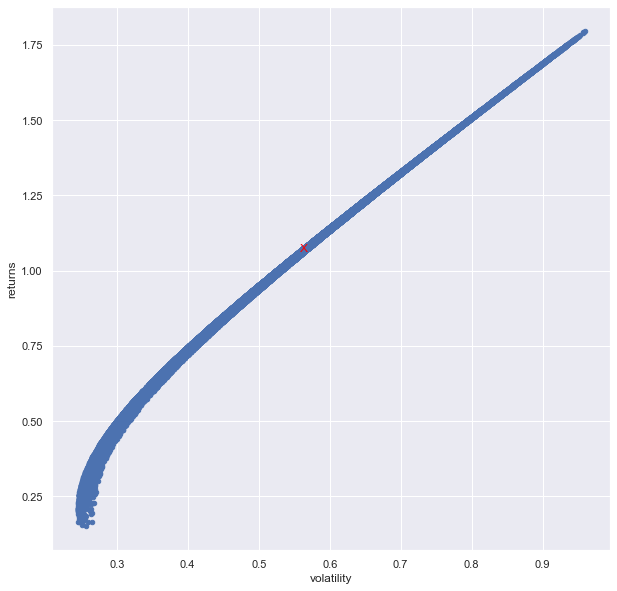

In [176]:
simulation_portfolios.plot.scatter(x='volatility', y='returns', figsize=(10,10), grid=True);
plt.annotate('X', (best_port['volatility'],best_port['returns']), color='red');

In [177]:
simulation_portfolios = monte_carlo(final_return[['bova11', 'smal11', 'bitcoin', 'ether']], 100000)
best_port = simulation_portfolios.iloc[0]
simulation_portfolios.head()

returns  volatility  return_risk_ratio  bova11_weight  smal11_weight  bitcoin_weight  ether_weight
64939  1.05911     0.55531            1.90725        0.00045        0.45215         0.37069       0.17671
41806  1.06063     0.55610            1.90724        0.00063        0.45103         0.45017       0.09817
60681  1.05792     0.55469            1.90724        0.00057        0.45275         0.10401       0.44267
52996  1.05621     0.55379            1.90724        0.00050        0.45387         0.40587       0.13976
27948  1.06632     0.55910            1.90722        0.00146        0.44670         0.28800       0.26385

In [178]:
best_port

returns             1.05911
volatility          0.55531
return_risk_ratio   1.90725
bova11_weight       0.00045
smal11_weight       0.45215
bitcoin_weight      0.37069
ether_weight        0.17671
Name: 64939, dtype: float64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


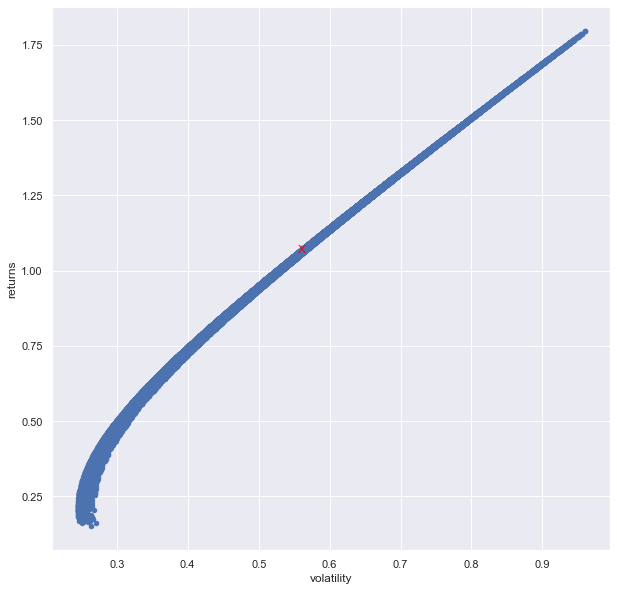

In [179]:
simulation_portfolios.plot.scatter(x='volatility', y='returns', figsize=(10,10), grid=True);
plt.annotate('X', (best_port['volatility'],best_port['returns']), color='red');

Nossa simulação de Monte Carlo apontou algo que já podíamos imaginar a partir da Análise Exploratória de Dados: a prevalência de rentabilidade das criptomoeda. Pelo resultado da simulação, pode-se notar que os portfolio ideias majoritariamente formados pelo Bitcoin e pelo Ether, de modo que nenhum outro ativo ultrapassou 10% de composição da carteira.

Essa prevalência das criptomoedas faz com que a rentabilidade seja bastante significa, assim como o risco seja bastante acentuado. Assim sendo, lançaremos mão da visualização da Fronteira Eficiente precisamente para identificar alguns portfólios que otimizam essa relação entre retorno e risco.

In [180]:
# Dolar -> XGB
# BOVA11 --> XGB
# SMALL11 --> XGB
# BITCOIN --> Random Forest
# Ether --> Random Forest


### 9.2 Fronteira Eficiente

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


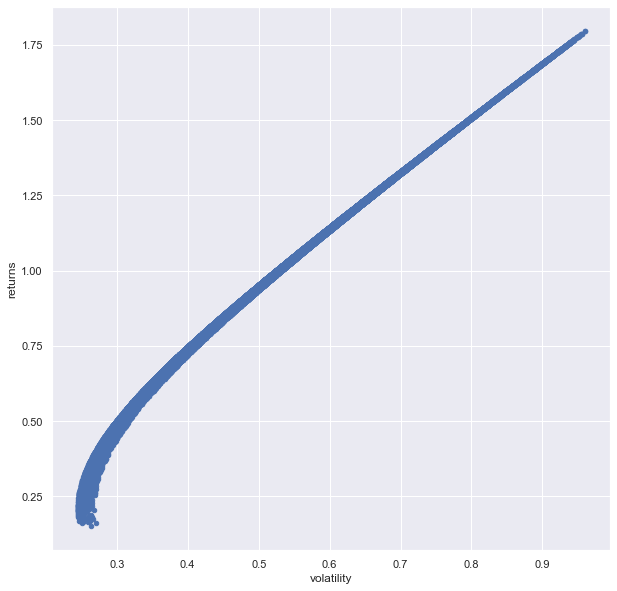

In [181]:
simulation_portfolios.plot.scatter(x='volatility', y='returns', figsize=(10,10), grid=True);

# 10.0 Deploy